# Exploratory Data Analysis - MultiCamFall

### Setup

In [2]:
import pandas as pd
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sns
from summarytools import dfSummary
import cv2
import mediapipe as mp
import os
import tensorflow as tf
from tqdm import tqdm
import pickle

DATA_PATH = '/Users/kai/workspace/data/MultiCamFall'
VIDEO_PATH = '/Users/kai/workspace/data/MultiCamFall/dataset/dataset'

In [3]:
df = pd.read_csv(DATA_PATH + '/data_tuple3.csv')

### Summary

### Observations

* Apply transforms based on the EDA findings...

In [4]:
# Calculate duration of each video segment
df['duration'] = df['end'] - df['start']
df.loc[df["cam"] == 55, "cam"] = 3.0

In [5]:
dfSummary(df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,chute[float64],Mean (sd) : 12.6 (7.0)min < med < max:1.0 < 12.0 < 23.0IQR (CV) : 13.0 (1.8),23 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAq1JREFUeJzt3MGK2lAUgOGTZpSMQoIIuvMFCl249CH6sH2ELnwC38CdIBIxM8EYM4tBGEqbxHtzm5zk//ZRFz91zum9ekVRCNB139r+AEAdL21/AHSH53mvIjK2eIlrURTvTX2erwgVIvIZ6Xw+/xmG4cz0Nc7n88nzvF8uYiVUPIzDMJxtNpv3KIrSZx+O4zjYbrez4/E4FhFChVtRFKWLxeLN8PHXRj/MFwxTUIFQoQJf/WhMnucjEQk9zzN5vHRjQKhoRJIkoyzLfqxWK9/3/aeHsaqNAaGiEdfr9SUIgsl6vU6Xy+XpmWfrbAwIFY2aTqemW4PSjQHDFFQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUqPyfKcvrCc6uJmBYSkO1vZ7g8moChqXqX1Tj6wmuryZgWGodSrG4nuDsagKGhWEKKhAqVHB6HtXyaoKI0q0Bm5LmOQvV9mqCiM6tAZsSN5yFanM1QUT11oBNiQPOr6JYXE0QUbw1YFPSLIYpqECoUKHTt1Bd/qBBFYvJPbzf7yPT98XfdTZU1z9oUMZmcs+yLMjz/Huapr9FxPRvc/yhs6G6/kGDCsaT+36/n+12u8ntdvMN3hf/0NlQH1z9oEEdJpP76XRianeAYQoqECpU6PxXvynLjUFrk/tQz0dU6WWothuDtib3oZ6PqKOXodqeM2hrch/w+YhKvQz1wXRj0PbkPtTzEWUYpqACoUKFXn/1D5HF1qDTZxQItUdstgZdP6NAqD1iszXo+hkFQu0hk61B25uOKgxTUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCrUu98VxHDz7wpfLJRARSZIkOBwOk//5vNb31vq5bZ+v09cHuATGoW0IwUcAAAAASUVORK5CYII="">",0(0.0%)
2,cam[float64],1. 1.02. 2.03. 3.04. 4.05. 5.06. 6.07. 7.08. 8.0,69 (12.5%)69 (12.5%)69 (12.5%)69 (12.5%)69 (12.5%)69 (12.5%)69 (12.5%)69 (12.5%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAC4CAYAAAD0WZ4UAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAqJJREFUeJzt3EFq21AARdGvYkIzkTAGL8aL6GK7CO3GGGvQhEzcQYftLOIG3HMW8MngIiPxX6bH4zGg8O2r/wD+H2IjIzYyYiMjNjJiIzONMV7HGC87nffxeDzedjqLJ3M4nU4/5nk+7nHYtm23aZp+Co5/OczzfLxcLm/Lsrx/5qD7/f59Xdfj9Xp9GWOIjb8cxhhjWZb38/n8a4fzXnc4gyflBYGM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MYYw/14M+e9AeZ/DcDtu23dZ1PY4drgdt23YbY3x8/s/iGbkWTmby7xeoeLKRMXghY/BCxuCFjI+6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZAxeyBi8kHEtnIzBCxkvCGT8jJKxriJjXUXGuoqMFwQyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIuBZOxrqKjCcbGYMXMgYvZAxeyPioS0ZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxnXwskYvJDxgkDGzygZ6yoy1lVkrKvIeEEgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjY11FxrqKjGvhZKyryHiykTF4IWPwQsbghYyPumTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsa6iox1FRkbBDLWVWQ82chYV5GxriJjXUXGR10yYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IuBZOxuCFjCcbGYMXMgYvZAxeyPioS0ZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZKyryFhXkbFBIGNdRcYLAhmxkREbGbGRERuZ3y2VroQVOKytAAAAAElFTkSuQmCC"">",0(0.0%)
3,start[float64],Mean (sd) : 745.9 (613.7)min < med < max:240.0 < 606.0 < 4166.0IQR (CV) : 288.5 (1.2),351 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAmFJREFUeJzt3T2O2lAUhuFz+Ys9IANyBjqaFHQUlCxiFpstILEAeoq0CGtkhAOBOE4TokiRAF+LhA+9T825pniF7ebgiqIw4NHV/vcXAG7RuPYB51xoZi3P849FUew9Z4HfLobqnAvjOH6Loqjvc/h2u313zn0mVlR17Re1FUVRfzab7bvd7qHMwWmaBovFop8kScvMCBWVXL31m5l1u93DYDD46nF+6DED/IWXKUggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEi4aaWPrzzPm2YWOed8j2AbIMzsjqFmWdY8nU6T0WhUr9frpRasnbENEGd3C/V4PDaCIHiZTqeH4XD4XnaebYD4011v/WZm7XbbdxOgGdsA8QsvU5BAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBw95U+VVTcBsgmwCfysKFW3QbIJsDn8rChVtkGmKZpMJ/PB0mSfHTObX2/ApE/jocN9cxnGyC7WZ/Pw4fqg92sz+cpQz1jN2s5zrnQzFoVjqiZ2Q/P2YuPWk8dKm7nnAvjOH6LoqjvM5/neTPLsk+dTmdVq9VOZeevPWrdFGqapkHZC+92u8DMLMuyYL1ev/zL+arXTtM0yPO8YdX+KENN1Ol0XieTyfcwDL+VHd5sNsFqtXodj8dfer3erszsfr//sFwuLz5q/QRt9uX/86Nj3AAAAABJRU5ErkJggg=="">",0(0.0%)
4,end[float64],Mean (sd) : 775.9 (613.7)min < med < max:270.0 < 636.0 < 4196.0IQR (CV) : 288.5 (1.3),351 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAA

### Observations

* The duration of every video segment is 30 frames.
* This is hard to believe, since I imagine each fall takes a variable amount of time. 

### Setup

* Next I'll check the start and end frames of each video segment for a fall and not fall example, to see what's going on.

In [77]:

cap = cv2.VideoCapture(VIDEO_PATH + f"/chute02/cam2.avi")
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("Total frames reported:", total_frames)
cap.release()

Total frames reported: 846


In [78]:
cap = cv2.VideoCapture(VIDEO_PATH + f"/chute02/cam2.avi")

frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_count += 1
    cv2.imshow('Frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

print("Total frames read:", frame_count)
cap.release()
cv2.destroyAllWindows()

2025-02-08 20:49:16.077 python[46826:13200833] +[IMKClient subclass]: chose IMKClient_Modern
2025-02-08 20:49:16.077 python[46826:13200833] +[IMKInputSession subclass]: chose IMKInputSession_Modern
[mpeg4 @ 0x17f6734c0] ac-tex damaged at 38 16
[mpeg4 @ 0x17f6734c0] Error at MB: 774


Total frames read: 846


### Global Settings

In [130]:
# Hard-coding FPS because the API is getting the wrong FPS (120)
FPS = 30 # cap.get(cv2.CAP_PROP_FPS)
FRAME_WIDTH = 224 # Resize for MobileNetV2 feature extraction
FRAME_HEIGHT = 224
PREFALL_TIME_MS = 500
PREFALL_OVERLAP_MS = 100
NUM_WINDOW_FRAMES = int((PREFALL_TIME_MS / 1000 * FPS)*2)
WINDOW_BUFFER_BEFORE_FALL = 3
WINDOW_BUFFER_AFTER_FALL = 1
FRAMES_CAPTURED_BEFORE_FALL = NUM_WINDOW_FRAMES * WINDOW_BUFFER_BEFORE_FALL
FRAMES_CAPTURED_AFTER_FALL = NUM_WINDOW_FRAMES * WINDOW_BUFFER_AFTER_FALL
MP_MODEL_PATH = '/Users/kai/workspace/aai_530/models/pose_landmarker_heavy.task'


In [7]:
# Suppress OpenCV logging because it's too verbose and 
# the occasional error does not appear to cause any issues getting frame data
os.environ['OPENCV_LOG_LEVEL'] = 'OFF'
os.environ['OPENCV_FFMPEG_LOGLEVEL'] = "-8"

def get_video_data(chute, cam, start_fall_frame, end_fall_frame, prefall_time_ms = None, prefall_overlap_ms = None, limit_to_prepost_frames=False) -> \
    tuple[list[np.ndarray], list[np.ndarray], list[np.ndarray]]:
    """
    Extract a sequence of frames from a video file and generate labels based on fall event timing.
    Processes the entire video, marking frames between start_fall_frame and end_fall_frame as fall events.
    Each frame is converted to RGB, resized, and normalized. Frame timestamps are calculated based on FPS.

    Args:
        chute (int): The chute number identifying the video scenario
        cam (int): The camera number identifying the video perspective
        start_fall_frame (int): The frame number where the fall begins
        end_fall_frame (int): The frame number where the fall ends
        prefall_time_ms (int): Amount of time before fall to include (in milliseconds)
        prefall_overlap_ms (int): Amount of time overlap between prefall and fall to include (in milliseconds)
        limit_to_prepost_frames (bool): Whether to limit the frames to a pre/post fall frame range defined by global settings FRAMES_CAPTURED_BEFORE_FALL and FRAMES_CAPTURED_AFTER_FALL

    Returns:
        tuple[np.ndarray, np.ndarray, np.ndarray]: A tuple containing:
            - Video frames as RGB numpy arrays, resized and normalized to [0,1]
            - Binary labels for each frame (1.0 for fall frames, 0.0 otherwise)
            - Frame timestamps in milliseconds
    """
    PRE_PROCESS_VERSION = 3

    if prefall_time_ms is not None:
        start_prefall_frame = start_fall_frame - ((prefall_time_ms / 1000) * FPS)
    if prefall_overlap_ms is not None:
        end_prefall_frame = start_fall_frame + ((prefall_overlap_ms / 1000) * FPS)
    else:
        end_prefall_frame = start_fall_frame

    # Read the video path to access the video files
    video_path = os.path.join(VIDEO_PATH, f"chute{chute:02d}", f"cam{cam}.avi")
    cap = cv2.VideoCapture(video_path)
    
    if limit_to_prepost_frames:
        start_at_frame = max(1, start_fall_frame - FRAMES_CAPTURED_BEFORE_FALL)
        end_at_frame = end_fall_frame + FRAMES_CAPTURED_AFTER_FALL
    else:
        start_at_frame = 0
        import sys
        end_at_frame = sys.maxsize

    #Setup the lists to append frames, labels, and frames_ts
    frame_no = 1
    raw_frames = []
    frames = []
    labels = []
    frames_ts = []
    frame_numbers = []

    # Read the first frame
    ret, frame = cap.read()

    # Loop over the frames
    while ret:
        # Skip frames outside of the start and end frames
        if frame_no < start_at_frame or frame_no > end_at_frame:
            ret, frame = cap.read()
            frame_no += 1
            continue
        
        raw_frames.append(frame)

        # Create cache directory structure if it doesn't exist
        cache_dir = os.path.join('pre_processed_frame_cache', f'v{PRE_PROCESS_VERSION}')
        os.makedirs(cache_dir, exist_ok=True)
        
        # Create chute and camera subdirectories if they don't exist
        chute_dir = os.path.join(cache_dir, f'{chute:02d}')
        cam_dir = os.path.join(chute_dir, f'cam{cam}')
        os.makedirs(cam_dir, exist_ok=True)
        
        # Check if cached frame exists
        cache_file = os.path.join(cam_dir, f'{frame_no}.npy')

        if os.path.exists(cache_file):
            # Load pre-processed frame from cache
            processed_frame = np.load(cache_file)
        else:
            # Pre-process frame
            processed_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            processed_frame = cv2.resize(processed_frame, (FRAME_WIDTH, FRAME_HEIGHT))
            processed_frame = processed_frame.astype(np.float32) / 255.0
            
            # Save to cache
            np.save(cache_file, processed_frame)
            
        frame_timestamp_ms = round(frame_no / FPS * 1000)
        frames.append(processed_frame) 
        frames_ts.append(frame_timestamp_ms)
        if prefall_time_ms is None:
            label = 1 if frame_no >= start_fall_frame and frame_no <= end_fall_frame else 0
        else:
            label = 1 if frame_no >= start_prefall_frame and frame_no <= end_prefall_frame else 0
        labels.append(label)
        frame_numbers.append(frame_no)

        frame_no += 1

        # Read the next frame
        ret, frame = cap.read()

    # Release the video capture
    cap.release()
    
    return np.array(raw_frames), \
        np.array(frames), \
        np.array(labels, dtype=np.float32),\
        np.array(frames_ts, dtype=np.float32),\
        np.array(frame_numbers, dtype=np.int32)


In [18]:
chute = 1
cam = 1
#Obtain a mini sample for testing
df_sample = df[(df['chute'] == chute) & (df['cam'] == cam) & (df['label'] == 1)]
display(df_sample.head())
start_fall_frame = df_sample['start'].values[0]
end_fall_frame = df_sample['end'].values[0]

# Assign different variables that simulate X, Y, only for sample
X_samp = []
Y_samp = []
ts_samp = []

# Lets obtain all of the data
raw_frames, frames, labels, frames_ts, frame_numbers = get_video_data(chute, cam, start_fall_frame, end_fall_frame, PREFALL_TIME_MS, PREFALL_OVERLAP_MS, limit_to_prepost_frames=True)
# frames, labels, frames_ts = get_video_data(chute, cam, start_fall_frame, end_fall_frame)
print(f"raw_frames.shape: {raw_frames.shape}")
print(f"frames.shape: {frames.shape}")
print(f"labels.shape: {labels.shape}")
print(f"frames_ts.shape: {frames_ts.shape}")
print(f"frame_numbers.shape: {frame_numbers.shape}")

,chute,cam,start,end,label,duration
1,1.0,1.0,1083.0,1113.0,1.0,30.0


raw_frames.shape: (95, 480, 720, 3)
frames.shape: (95, 224, 224, 3)
labels.shape: (95,)
frames_ts.shape: (95,)
frame_numbers.shape: (95,)


### Feature Extraction - MobileNetV2

* I'll use the pretrained MobileNetV2 model to extract features from the frames.

In [700]:
# Load Pretrained CNN (Feature Extractor)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(FRAME_HEIGHT, FRAME_WIDTH, 3),
    include_top=False,  # Remove classification layer
    pooling="avg"  # Global Average Pooling
)

def extract_features(chute, cam, video_sequence, frame_numbers):
    """
    Extracts CNN features from a video sequence.
    
    Args:
        video_sequence (np.ndarray): Shape (<num_frames>, 224, 224, 3)
        
    Returns:
        np.ndarray: Shape (<num_frames>, 1280) (<num_frames> frames, 1280 feature dimensions)
    """
    FEATURE_EXTRACTOR_VERSION = 1

    # Process each frame individually and stack results
    features = []
    for frame, frame_no in zip(video_sequence, frame_numbers):
        cache_dir = os.path.join('feature_cache', f'v{FEATURE_EXTRACTOR_VERSION}')
        os.makedirs(cache_dir, exist_ok=True)

        # Create chute and camera subdirectories if they don't exist
        chute_dir = os.path.join(cache_dir, f'{chute:02d}')
        cam_dir = os.path.join(chute_dir, f'cam{cam}')
        os.makedirs(cam_dir, exist_ok=True)

        # Check if cached feature exists
        cache_file = os.path.join(cam_dir, f'{frame_no}.npy')
        
        if os.path.exists(cache_file):
            # Load cached feature
            frame_features = np.load(cache_file)
        else:
            # Extract features
            frame_features = base_model.predict(np.expand_dims(frame, axis=0), verbose=0)[0]
        
        # Save to cache
        np.save(cache_file, frame_features)
        
        features.append(frame_features)
    return np.array(features)  # Shape: (90, 1280)

# Example usage
features = extract_features(chute, cam, frames, frame_numbers)
print("Shape of extracted features:", features.shape)  

Shape of extracted features: (95, 1280)


### Feature Extraction - 3D Pose Estimation

In [8]:
from ultralytics import YOLO

def get_people(image):
    # Load YOLO model
    model = YOLO('yolo11m.pt')
    
    # Run inference on the image with verbose=False to silence output
    results = model(image, verbose=False)
    
    # Initialize list to store cropped person images
    cropped_people = []
    
    # Get detections for the 'person' class (class 0 in COCO)
    for r in results:
        boxes = r.boxes
        for box in boxes:
            # Check if detection is a person (class 0)
            if box.cls == 0:
                # Get coordinates with 20% padding
                x1, y1, x2, y2 = box.xyxy[0]
                width = x2 - x1
                height = y2 - y1
                padding_x = int(width * 0.4)
                padding_y = int(height * 0.4)
                
                # Add padding while keeping within image bounds
                x1 = max(0, int(x1 - padding_x))
                y1 = max(0, int(y1 - padding_y))
                x2 = min(image.shape[1], int(x2 + padding_x))
                y2 = min(image.shape[0], int(y2 + padding_y))
                
                # Crop image
                person = image[y1:y2, x1:x2]
                cropped_people.append(person)
    
    return cropped_people

In [9]:
def get_segmentation_mask(image, model):
    """Get segmentation mask for people in the image using YOLOv8 segmentation model.
    
    Args:
        image: Input image
        model: YOLO segmentation model
        
    Returns:
        Binary mask where 1 indicates person pixels and 0 indicates background
    """
    # Run segmentation
    results = model(image, conf=0.3, verbose=False)[0]
    
    # Initialize empty mask
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    
    # For each detected person
    if results.masks:
        for seg in results.masks:
            # Get segmentation mask
            person_mask = seg.data[0].numpy()
        
            # Resize mask to match image dimensions
            person_mask = cv2.resize(person_mask, (image.shape[1], image.shape[0]))
            
            # Add to overall mask
            mask = np.logical_or(mask, person_mask).astype(np.uint8)
        
    return mask


In [10]:
import cv2
from ultralytics import YOLO

def process_frame_for_pose_estimation(frame):
    model = YOLO('yolo11m-seg.pt')
    segmentation_mask = get_segmentation_mask(frame, model)

    # Apply blur to background using the mask
    blurred_background = cv2.GaussianBlur(frame, (0, 0), 15)  

    # Blend the blurred background with foreground using the mask
    mask = segmentation_mask[..., np.newaxis]  # Add channel dimension to match image
    result = frame * mask + blurred_background * (1 - mask)  # Blend based on mask values
    # Normalize the result to be between 0 and 1
    return result 

In [11]:
def center_pose(joints, center_idx=0):
    """
    Normalizes pose by making the center joint the origin.
    
    Args:
        joints (np.ndarray): Shape (N_joints, 3) - Original 3D pose
        center_idx (int): Index of the joint to use as the center (e.g., hip/spine)
    
    Returns:
        np.ndarray: Centered pose with the root joint at (0,0,0)
    """
    center_joint = joints[center_idx]  # Get the root joint (e.g., spine or pelvis)
    return joints - center_joint  # Subtract it from all joints

def scale_pose(joints, normalization_factor="torso"):
    """
    Scales pose to remove subject height dependence.
    
    Args:
        joints (np.ndarray): Shape (N_joints, 3) - Centered 3D pose
        normalization_factor (str): 'torso' or 'full_height'
    
    Returns:
        np.ndarray: Scale-normalized pose
    """
    if normalization_factor == "torso":
        # Compute distance between shoulders & hips (torso height)
        torso_height = np.linalg.norm(joints[2] - joints[8])  # Example: Shoulders-Hip distance
        scale = max(torso_height, 1e-5)  # Avoid division by zero
    else:
        # Compute full body height (head to feet)
        height = np.linalg.norm(joints[0] - joints[15])  # Example: Head to ankle distance
        scale = max(height, 1e-5)

    return joints / scale  # Normalize all joints

def normalize_pose(joints):
    """
    Normalizes pose by centering and scaling.
    
    Args:
        joints (np.ndarray): Shape (N_joints, 3) - Original 3D pose
        
    Returns:
        np.ndarray: Normalized pose
    """
    centered_joints = center_pose(joints)
    scaled_joints = scale_pose(centered_joints)
    return scaled_joints


In [12]:
import mediapipe as mp

BaseOptions = mp.tasks.BaseOptions
PoseLandmarker = mp.tasks.vision.PoseLandmarker
PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

# Create a pose landmarker instance with the video mode:
options = PoseLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=MP_MODEL_PATH),
    running_mode=VisionRunningMode.VIDEO,
    num_poses=1,
    min_pose_detection_confidence=0.5,
    min_pose_presence_confidence=0.5,
    min_tracking_confidence=0.5,
    )

In [13]:
# Interpolate missing poses (frames with all zeros)
def interpolate_missing_poses(pose_features):
    """
    Interpolates missing poses (frames with all zeros) using linear interpolation between
    nearest non-zero poses.
    
    Args:
        pose_features (np.ndarray): Array of pose features, shape (num_frames, 99)
        
    Returns:
        np.ndarray: Interpolated pose features array of same shape
    """
    interpolated = pose_features.copy()
    zero_frames = np.where(~interpolated.any(axis=1))[0]
    
    if len(zero_frames) == 0:
        return interpolated
        
    for zero_frame in zero_frames:
        # Find nearest previous non-zero frame
        prev_idx = zero_frame - 1
        while prev_idx >= 0 and not interpolated[prev_idx].any():
            prev_idx -= 1
            
        # Find nearest next non-zero frame    
        next_idx = zero_frame + 1
        while next_idx < len(interpolated) and not interpolated[next_idx].any():
            next_idx += 1
            
        # Skip if we can't find both previous and next frames
        if prev_idx < 0 or next_idx >= len(interpolated):
            continue
            
        # Get previous and next non-zero poses
        prev_pose = interpolated[prev_idx]
        next_pose = interpolated[next_idx]
        
        # Calculate interpolation weight based on frame position
        weight = (zero_frame - prev_idx) / (next_idx - prev_idx)
        
        # Linear interpolation
        interpolated[zero_frame] = prev_pose + weight * (next_pose - prev_pose)
    
    return interpolated

In [14]:
import os
import sys
import logging

# Suppress TensorFlow & MediaPipe logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppresses TensorFlow INFO & WARNING logs
os.environ['GLOG_minloglevel'] = '3'      # Suppresses GLOG messages (used by MediaPipe)


# Redirect stdout and stderr to suppress MediaPipe logs
class SuppressLogs:
    def __enter__(self):
        self.stdout = sys.stdout
        self.stderr = sys.stderr
        sys.stdout = open(os.devnull, 'w')
        sys.stderr = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_value, traceback):
        sys.stdout.close()
        sys.stderr.close()
        sys.stdout = self.stdout
        sys.stderr = self.stderr

# Suppress Python warnings
logging.getLogger("mediapipe").setLevel(logging.ERROR)  # Suppress INFO and WARNING logs

import warnings
from IPython.utils import io
warnings.filterwarnings("ignore")

In [15]:
def extract_pose_features(
    chute,
    cam,
    video_sequence,
    frame_numbers,
    frames_ts,
    normalize_func=None,
    read_raw_from_cache=True,
    read_norm_from_cache=True,
    save_to_cache=True,
):
    """
    Extracts 3D pose landmarks from a video sequence using MediaPipe.

    Args:
        chute (int): The chute number identifying the video scenario
        cam (int): The camera number identifying the video perspective
        video_sequence (np.ndarray): Shape (<num_frames>, 224, 224, 3)
        frame_numbers (list): List of frame numbers

    Returns:
        np.ndarray: Shape (<num_frames>, 99) - 33 landmarks x 3 coordinates (x,y,z)
    """
    # Initialize MediaPipe Pose

    def get_raw_pose_features():
        raw_cache_dir = os.path.join(
            "pose_feature_cache", "raw_v1", f"{chute:02d}", f"cam{cam}"
        )
        os.makedirs(raw_cache_dir, exist_ok=True)

        raw_pose_features = []

        # Skip the entire PoseLandmarker initialization process if we have all the raw cached pose features
        for frame, frame_no, frame_timestamp_ms in zip(
                video_sequence, frame_numbers, frames_ts
            ):
                # Check if cached raw frame pose features exist
                raw_cache_file = os.path.join(raw_cache_dir, f"{frame_no}.npy")
                if read_raw_from_cache and os.path.exists(raw_cache_file):
                    raw_frame_pose = np.load(raw_cache_file)
                    raw_pose_features.append(raw_frame_pose)
                    continue
        if len(raw_pose_features) == video_sequence.shape[0]:
            return raw_pose_features

        # with io.capture_output() as captured:
        #     with SuppressLogs():
        with PoseLandmarker.create_from_options(options) as landmarker:
            # Process each frame individually and stack results
            for frame, frame_no, frame_timestamp_ms in zip(
                video_sequence, frame_numbers, frames_ts
            ):
                # Check if cached raw frame pose features exist
                raw_cache_file = os.path.join(raw_cache_dir, f"{frame_no}.npy")
                if read_raw_from_cache and os.path.exists(raw_cache_file):
                    raw_frame_pose = np.load(raw_cache_file)
                    raw_pose_features.append(raw_frame_pose)
                    continue

                raw_frame_pose = np.zeros(99)
                people = get_people(frame)
                if len(people) > 0:
                    person = people[0]  # For this project, we only have one person in the frame
                    processed_frame = process_frame_for_pose_estimation(person)
                    mp_image = mp.Image(
                        image_format=mp.ImageFormat.SRGB, data=processed_frame
                    )
                    result = landmarker.detect_for_video(
                        mp_image, int(frame_timestamp_ms)
                    )
                    if result.pose_landmarks:
                        if result.pose_world_landmarks:
                            raw_frame_pose = np.array(
                                [
                                    [lm.x, lm.y, lm.z]
                                    for lm in result.pose_world_landmarks[0]
                                ]
                            )
                if save_to_cache:
                    np.save(raw_cache_file, raw_frame_pose)
                raw_pose_features.append(raw_frame_pose)
        return raw_pose_features

    normalize_func_name = normalize_func.__name__ if normalize_func else "None"
    cache_dir = os.path.join(
        "pose_feature_cache", normalize_func_name, f"{chute:02d}", f"cam{cam}"
    )
    os.makedirs(cache_dir, exist_ok=True)

    # Detect raw 3D pose features
    raw_pose_features = get_raw_pose_features()

    # Normalize raw 3D pose features
    norm_features = []
    for frame_no, features in zip(frame_numbers, raw_pose_features):
        norm_cache_file = os.path.join(cache_dir, f"{frame_no}.npy")
        if read_norm_from_cache and os.path.exists(norm_cache_file):
            norm_features.append(np.load(norm_cache_file))
            continue

        normalized_landmarks = normalize_func(features)
        norm_features.append(np.array(
            normalized_landmarks
        ).flatten())  # Shape: (99,)

        if save_to_cache:
            np.save(norm_cache_file, norm_features[-1])

    norm_features = np.array(norm_features)
    # Interpolate any missing poses
    pose_features_filled = interpolate_missing_poses(norm_features)

    # Create mask showing which features have non-zero values (1) vs all zeros (0)
    feature_mask = np.any(pose_features_filled != 0, axis=0).astype(int)

    return np.array(pose_features_filled), np.array(
        feature_mask
    )  # Shape: (num_frames, 99)

In [19]:
# Run feature extraction again without caching to profile performance
pose_features, pose_feature_mask = extract_pose_features(
    chute,
    cam,
    raw_frames,
    frame_numbers,
    frames_ts,
    normalize_func=normalize_pose,
    read_raw_from_cache=True,
    read_norm_from_cache=True,
    save_to_cache=True,
)


### Setup

* Iterate on the extract_pose_features function with profiling
* Make sure caching is working correctly, including edge cases like when pose estimation fails

In [ ]:
# Profile the pose feature extraction
import cProfile
import pstats
from pstats import SortKey

pr = cProfile.Profile()
pr.enable()

# Run feature extraction again without caching to profile performance
pose_features, pose_feature_mask = extract_pose_features(
    chute,
    cam,
    raw_frames,
    frame_numbers,
    frames_ts,
    normalize_func=normalize_pose,
    read_raw_from_cache=True,
    read_norm_from_cache=True,
    save_to_cache=True,
)

pr.disable()

# Print profiling stats sorted by cumulative time
stats = pstats.Stats(pr).sort_stats(SortKey.CUMULATIVE)
stats.print_stats(20) # Show top 20 functions


Number of zero mask frames: 6


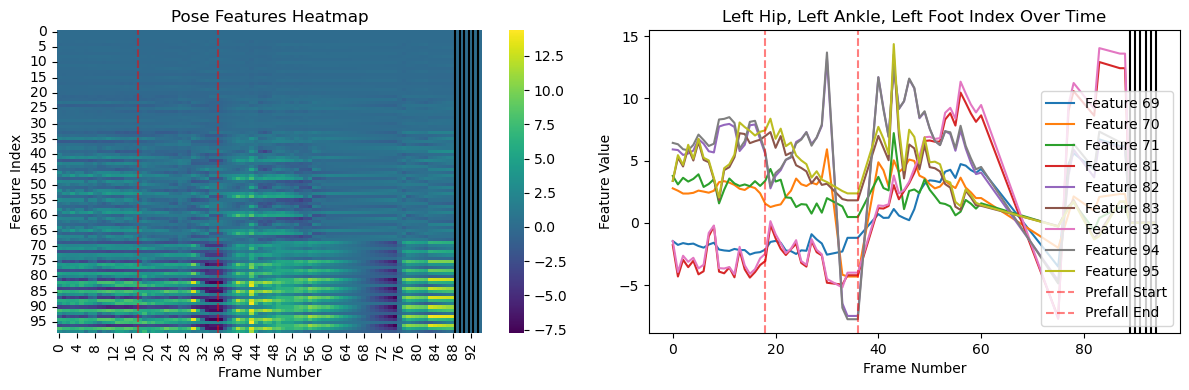

In [20]:
def plot_pose_features(pose_features, labels):
    # Visualize pose features across frames
    plt.figure(figsize=(12, 4))
    # Get indices where y==1 (prefall)
    prefall_start = np.where(labels==1)[0][0]
    prefall_end = np.where(labels==1)[0][-1]

    # Plot heatmap of pose features
    plt.subplot(121)
    sns.heatmap(pose_features.T, cmap='viridis')
    plt.axvline(x=prefall_start, color='red', linestyle='--', alpha=0.5, label='Prefall Start')
    plt.axvline(x=prefall_end, color='red', linestyle='--', alpha=0.5, label='Prefall End')
    # Add black vertical lines where pose_feature_mask is 0 (missing poses)
    zero_mask_frames = np.where(np.all(pose_features == 0, axis=1))[0]
    print(f"Number of zero mask frames: {len(zero_mask_frames)}")
    for frame in zero_mask_frames:
        plt.axvline(x=frame, color='black', linestyle='-', alpha=1.0)

    plt.title('Pose Features Heatmap')
    plt.xlabel('Frame Number')
    plt.ylabel('Feature Index')

    # Plot line plot of a few selected features
    plt.subplot(122)
    selected_features = [69, 70, 71, 81, 82, 83, 93, 94, 95]  # left_hip, left_ankle, left_foot_index
    for feature in selected_features:
        plt.plot(pose_features[:, feature], label=f'Feature {feature}')
    plt.axvline(x=prefall_start, color='red', linestyle='--', alpha=0.5, label='Prefall Start')
    plt.axvline(x=prefall_end, color='red', linestyle='--', alpha=0.5, label='Prefall End')
    # Add black vertical lines where pose_feature_mask is 0 (missing poses)
    zero_mask_frames = np.where(np.all(pose_features == 0, axis=1))[0]
    for frame in zero_mask_frames:
        plt.axvline(x=frame, color='black', linestyle='-', alpha=1.0)
    plt.title('Left Hip, Left Ankle, Left Foot Index Over Time')
    plt.xlabel('Frame Number')
    plt.ylabel('Feature Value')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_pose_features(pose_features, labels)

### Observations
* On the left is a heatmap of all pose data for each frame.  On the right is a plot of just some selected landmarks.  The red bars show not the fall, but the "pre-fall" conditions we're trying to predict; in this case with a 500ms horizon.  You can see the fall itself occurs soon after the "pre fall" event, the pose estimator loses track of the person mid-fall, and picks them up on the other side; on the ground. The straight lines are the interpolated missing poses. 
* Looking at the selected landmarks, it does seem as though there is a shift in pose prior to the fall
* It looks like the fall labels begin a bit before the actual fall as well, so our "pre fall" labels are missing that extra signal. 
* The interpolated missing poses are linear and simplistic. It might be better to use a smoother, non-linear interpolation approach.


In [21]:
import numpy as np

STRIDE = 3  # Number of frames to move the window each step

def create_sliding_windows(video_features, labels, feature_mask=None, window_size=NUM_WINDOW_FRAMES, stride=STRIDE):
    """
    Converts full video sequences into overlapping sliding windows.

    Args:
        video_features (np.ndarray): Shape (num_videos, 90, ?)
        labels (np.ndarray): Shape (num_videos, 1)
        window_size (int): Number of frames per sequence
        stride (int): Step size for moving window

    Returns:
        X_windows (np.ndarray): Sliding window features (num_windows, window_size, ?)
        y_windows (np.ndarray): Labels for each window (num_windows,)
    """
    X_windows, y_windows = [], []

    num_frames = video_features.shape[0]
    for j in range(0, num_frames - window_size + 1, stride):  # Slide over frames
        if feature_mask[j:j + window_size].all(): # If all frames in the window are not masked out
            window = video_features[j:j + window_size]  # Extract window from correct video
            X_windows.append(window)
            y_windows.append(labels[j + window_size - 1])  # Use video label for the end of the window

    return np.array(X_windows), np.array(y_windows)

# For now, just use the one video
# X_train = np.array([pose_features])  # Shape: (1, num_frames, num_features)
# y_train = np.array([labels])    # Shape: (1, num_frames)
# feature_masks = np.array([pose_feature_mask])

X_train_windows, y_train_windows = create_sliding_windows(pose_features, labels, pose_feature_mask)

print("Shape of X_train_windows:", X_train_windows.shape)  # (num_windows, 30, 1280)
print("Shape of y_train_windows:", y_train_windows.shape)  # (num_windows,)

Shape of X_train_windows: (21, 30, 99)
Shape of y_train_windows: (21,)


### Setup

* Define a function to get all training data and related metadata for a given dataframe of videos.
* The goal is to rapidly iterate on how training data is shaped and processed by leveraging the above functions built-in flexibility.

In [22]:
def get_data_for_videos(df, limit_to_prepost_frames=False):
    """
    Get data for videos in the dataframe.

    Args:
        df: DataFrame containing video information

    Returns:
        video_data: List of dictionaries containing video data:
            - X_train_windows: Sliding windows of features
            - y_train_windows: Labels for each window
            - frames: Frames from the video
            - features: Features extractedfrom the frames
            - labels: Labels for each frame
            - frames_ts: Timestamps for each frame
    """
    video_data = []

    for video in (
        pbar := tqdm(df.itertuples(), total=len(df), desc="Processing videos")
    ):
        pbar.set_postfix(chute=video.chute, cam=video.cam)
        raw_frames, frames, labels, frames_ts, frame_numbers = get_video_data(
            int(video.chute),
            int(video.cam),
            int(video.start),
            int(video.end),
            PREFALL_TIME_MS,
            PREFALL_OVERLAP_MS,
            limit_to_prepost_frames,
        )
        features, feature_mask = extract_pose_features(
            int(video.chute),
            int(video.cam),
            raw_frames,
            frame_numbers,
            frames_ts,
            normalize_func=normalize_pose,
            read_raw_from_cache=True,
            read_norm_from_cache=True,
            save_to_cache=True,
        )

        # Create sliding windows of features and labels
        X_train_windows, y_train_windows = create_sliding_windows(
            features, labels, feature_mask
        )

        # Append the data to the video_data list
        video_data.append(
            {
                "cam": video.cam,
                "chute": video.chute,
                "X_train_windows": X_train_windows,
                "y_train_windows": y_train_windows,
                "raw_frames": raw_frames,
                "frames": frames,
                "features": features,
                "labels": labels,
                "frames_ts": frames_ts,
                "frame_numbers": frame_numbers,
            }
        )
    return video_data

### Let's look at the pose features for all 8 camera angles for the same fall

In [85]:
df_chute1 = df[(df['chute'] == 1) & (df['label'] == 1)]
chute1_data = get_data_for_videos(df_chute1, limit_to_prepost_frames=True)

Processing videos: 100%|██████████| 8/8 [00:04<00:00,  1.61it/s, cam=8, chute=1]


## Chute 1.0 Cam 1.0

Number of zero mask frames: 6


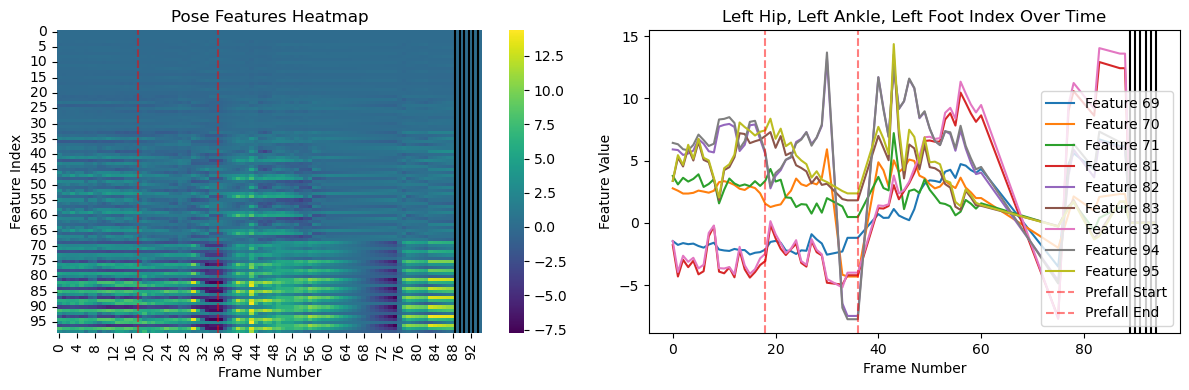

## Chute 1.0 Cam 2.0

Number of zero mask frames: 0


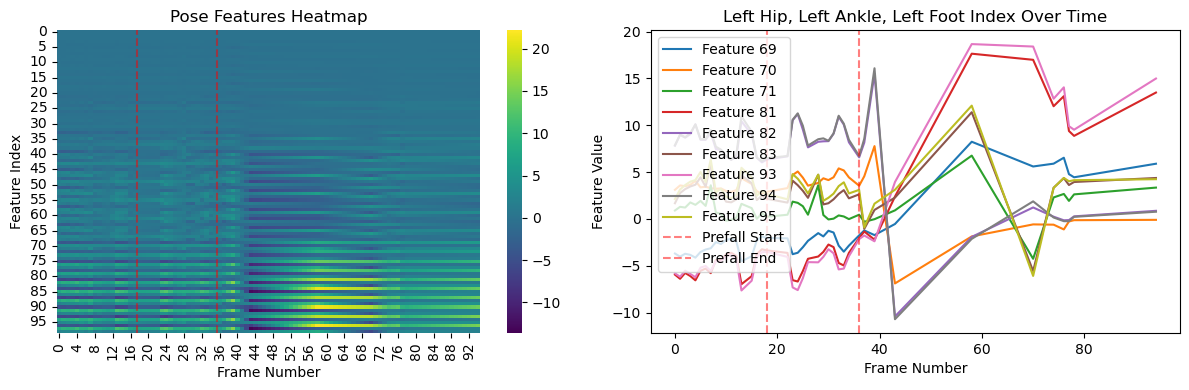

## Chute 1.0 Cam 3.0

Number of zero mask frames: 30


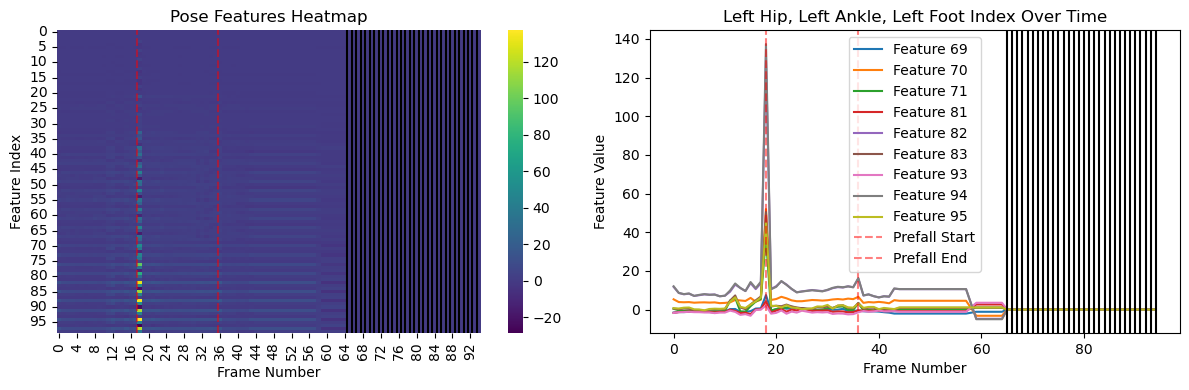

## Chute 1.0 Cam 4.0

Number of zero mask frames: 25


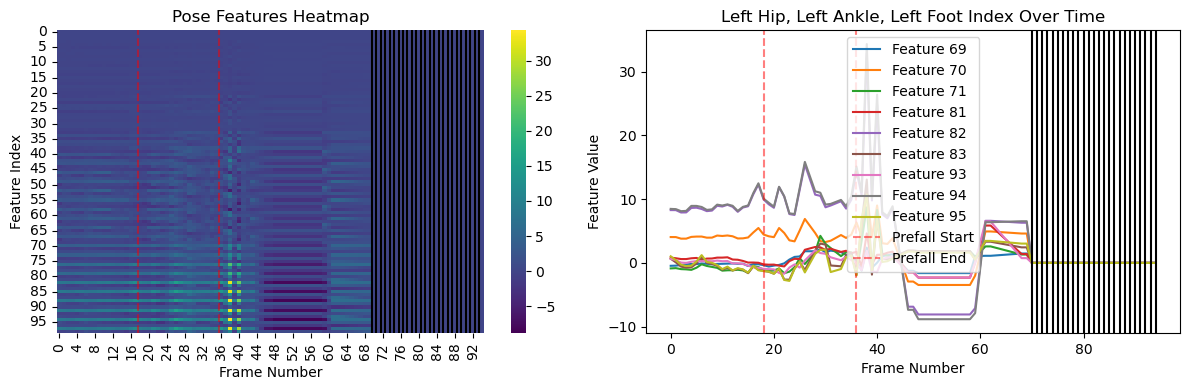

## Chute 1.0 Cam 5.0

Number of zero mask frames: 22


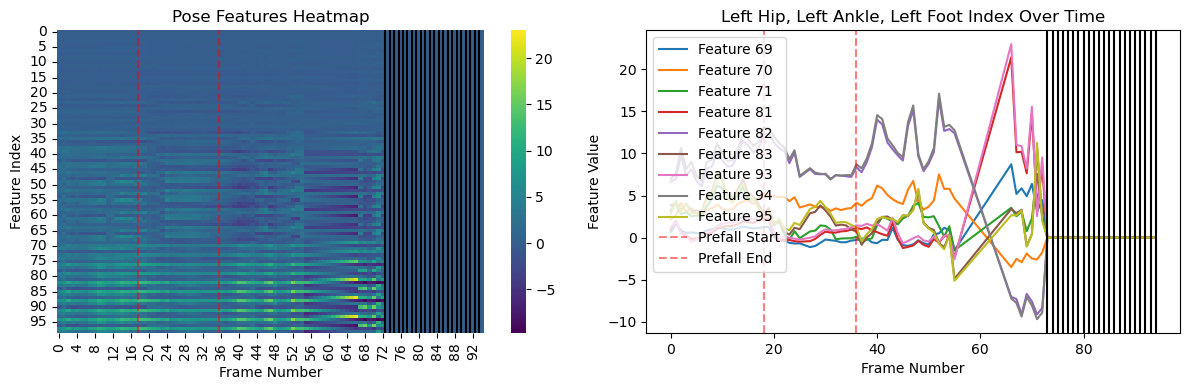

## Chute 1.0 Cam 6.0

Number of zero mask frames: 36


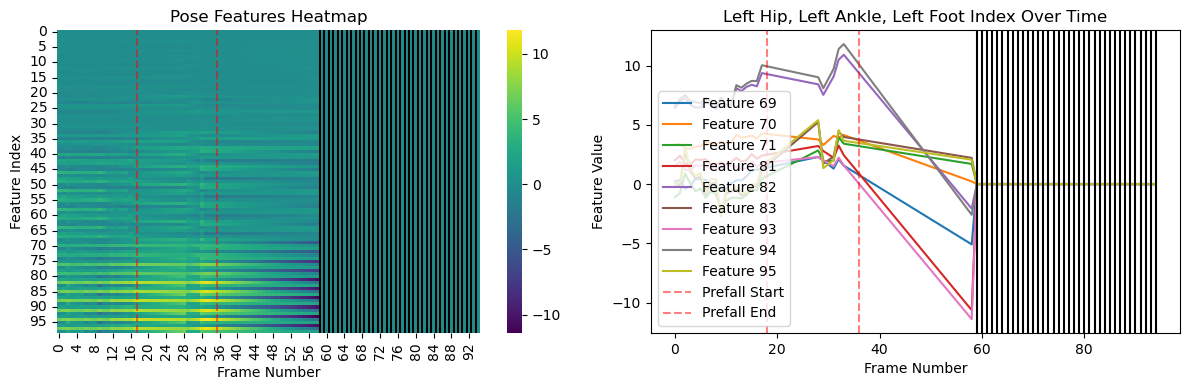

## Chute 1.0 Cam 7.0

Number of zero mask frames: 49


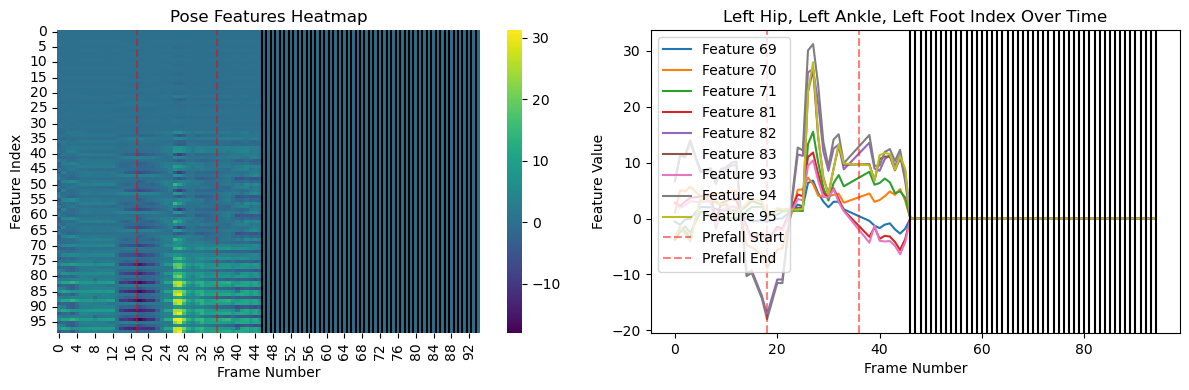

## Chute 1.0 Cam 8.0

Number of zero mask frames: 0


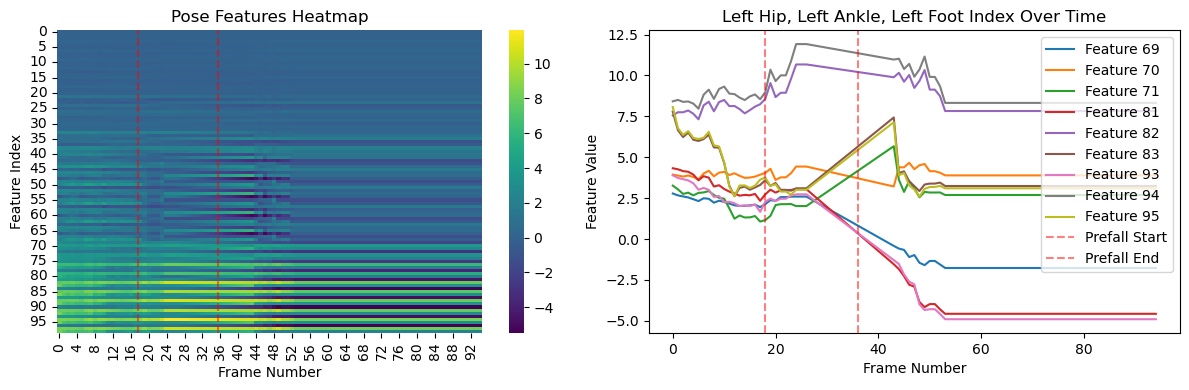

In [86]:
# Plot features for each video in chute1_data
for i, video_data in enumerate(chute1_data):
    features = video_data['features']
    labels = video_data['labels']
    chute = video_data['chute']
    cam = video_data['cam']
    display(Markdown(f"## Chute {chute} Cam {cam}"))
    plot_pose_features(features, labels)


### Observations

* It's clear from the heatmaps of the 8 camera angles that the same exact fall's pose features are very different depending on the camera angle. 
* I can understand why it would be hard for the model to generalize to all 8 camera angles. 
* I'm going to try to normalize the pose features across all camera angles, so the model can focus on learning about the fall, rather than the camera angle. 

## Chute 1 Cam 1

Number of zero mask frames: 25


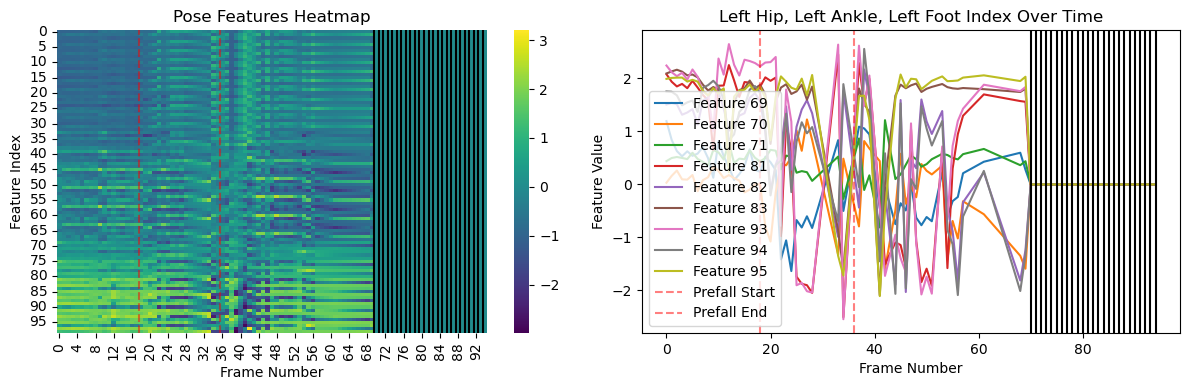

## Chute 1 Cam 2

Number of zero mask frames: 0


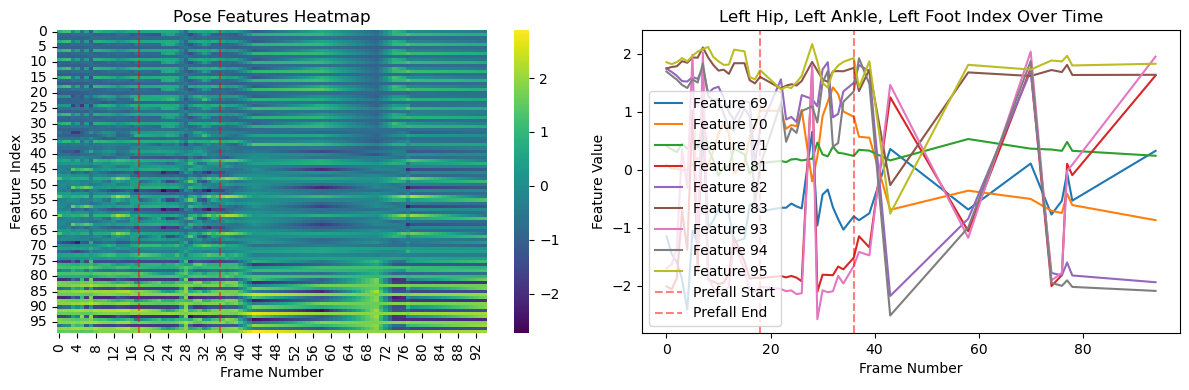

## Chute 1 Cam 3

Number of zero mask frames: 36


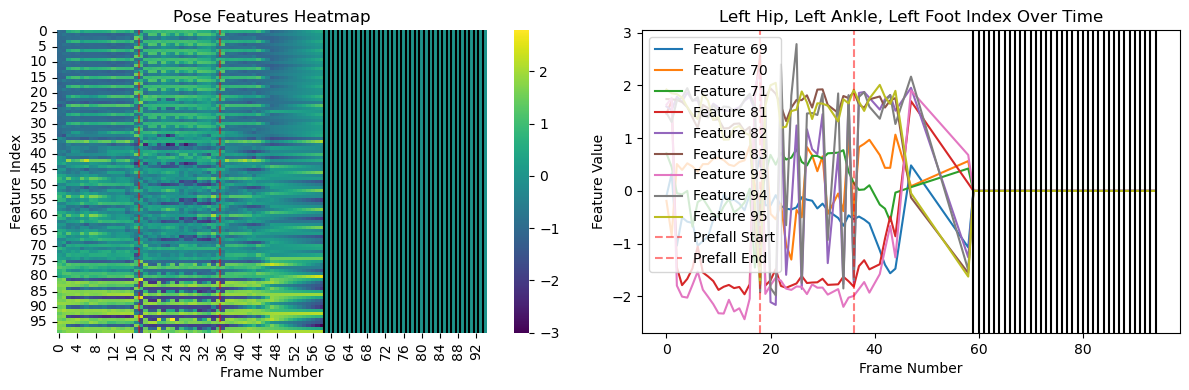

## Chute 1 Cam 4

Number of zero mask frames: 35


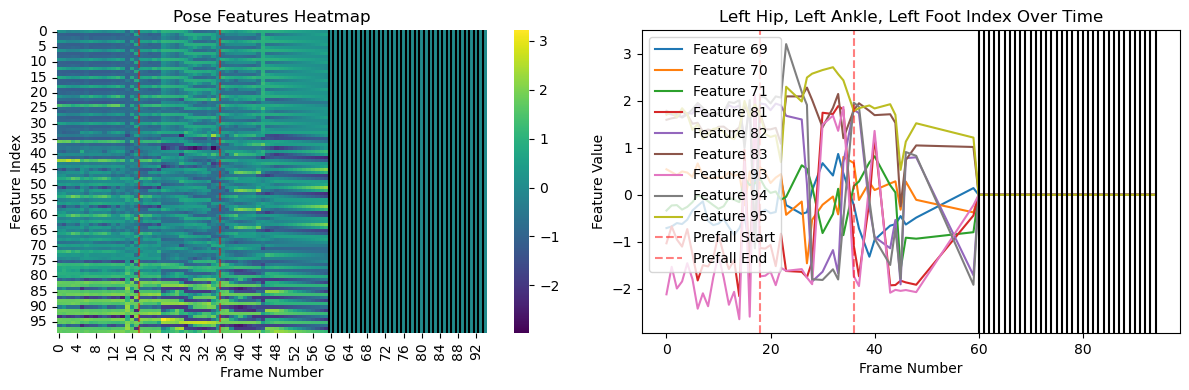

## Chute 1 Cam 5

Number of zero mask frames: 22


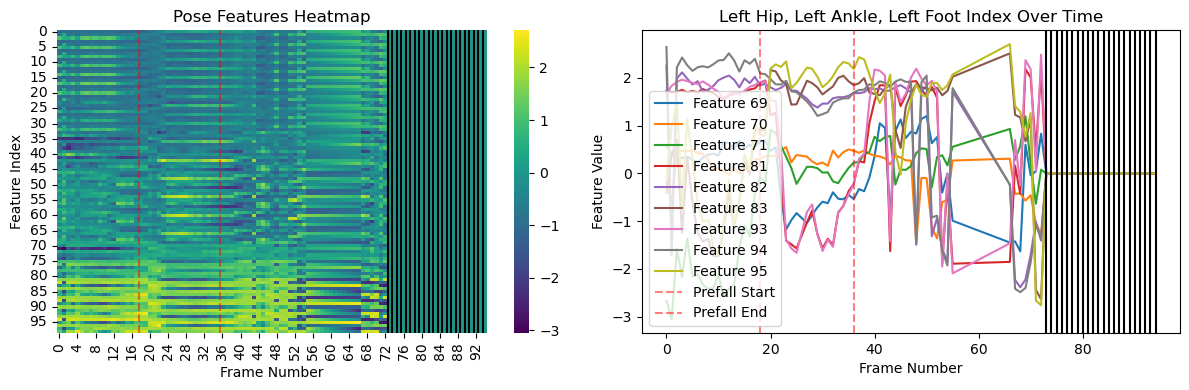

## Chute 1 Cam 6

Number of zero mask frames: 36


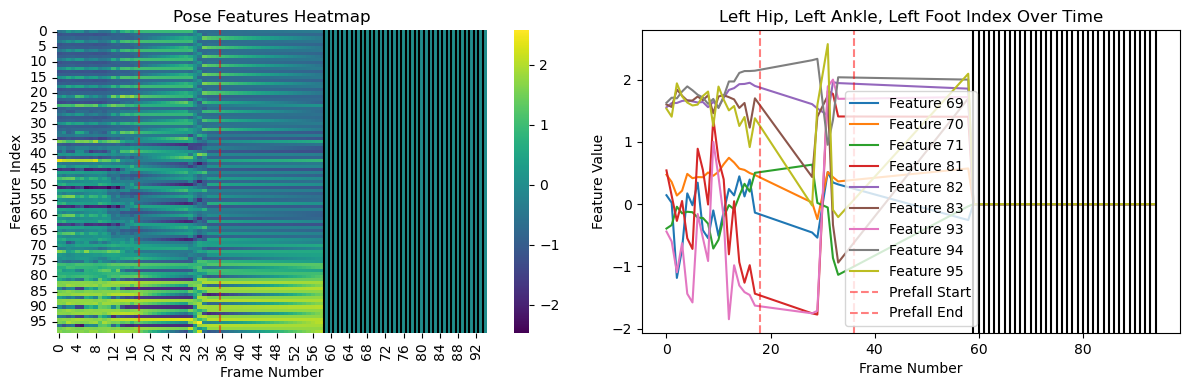

## Chute 1 Cam 7

Number of zero mask frames: 49


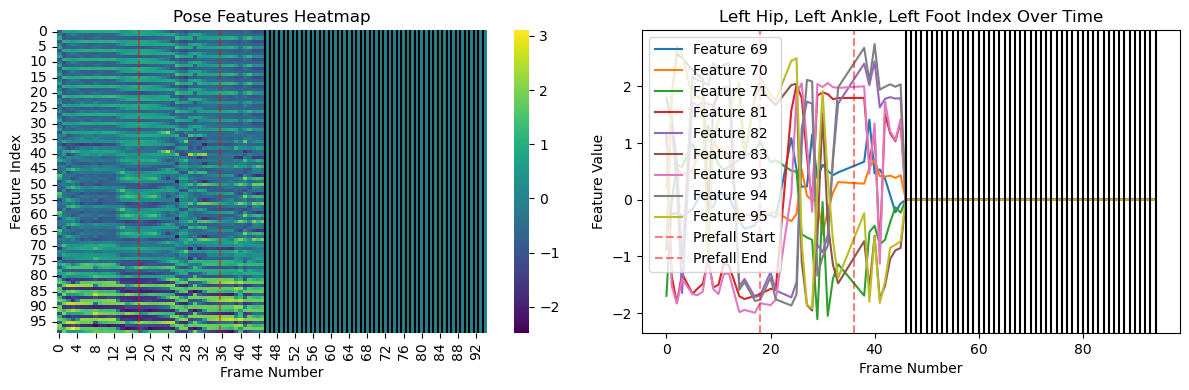

## Chute 1 Cam 8

Number of zero mask frames: 27


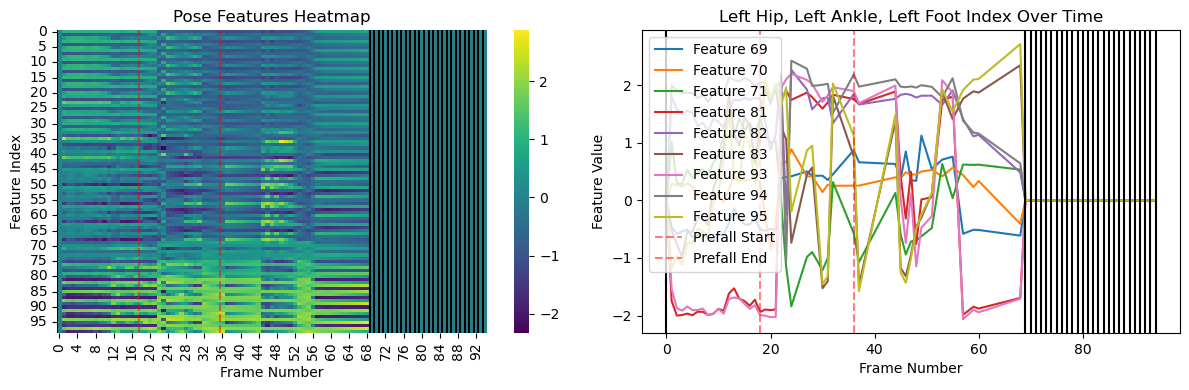

In [87]:
from scipy.spatial.transform import Rotation as R
from sklearn.preprocessing import StandardScaler

def normalize_pose_across_cameras(joints):
    """
    Normalizes the pose regardless of camera angle.

    Args:
        joints (np.ndarray): Shape (N_joints, 3) - Original 3D pose

    Returns:
        np.ndarray: Normalized pose
    """

    def center_pose(joints, center_idx=0):
        """
        Centers the 3D pose by making a specific joint (e.g., hip) the origin.
        
        Args:
            joints (np.ndarray): Shape (N_joints, 3) - Original 3D pose
            center_idx (int): Index of the joint to use as the center (default: hip/spine)

        Returns:
            np.ndarray: Centered pose with the root joint at (0,0,0)
        """
        center_joint = joints[center_idx]  # Reference joint (e.g., hip)
        return joints - center_joint  # Shift all joints

    def scale_pose(joints, normalization_factor="torso"):
        """
        Normalizes pose by removing subject height dependency.
        
        Args:
            joints (np.ndarray): Shape (N_joints, 3) - Centered 3D pose
            normalization_factor (str): 'torso' or 'full_height'

        Returns:
            np.ndarray: Scale-normalized pose
        """
        if normalization_factor == "torso":
            torso_height = np.linalg.norm(joints[2] - joints[8])  # Shoulders-Hip distance
            scale = max(torso_height, 1e-5)  # Avoid division by zero
        else:
            height = np.linalg.norm(joints[0] - joints[15])  # Head to ankle distance
            scale = max(height, 1e-5)

        return joints / scale  # Normalize all joints

    def align_pose_to_front(joints):
        """
        Aligns pose to a common front-facing orientation.
        
        Args:
            joints (np.ndarray): Shape (N_joints, 3) - Normalized 3D pose

        Returns:
            np.ndarray: Rotated pose with a standard front-facing orientation
        """
        # Compute "forward" vector (e.g., hips to shoulders)
        forward_vector = joints[2] - joints[8]  # Shoulders to Hip

        # Compute the rotation needed to align this vector to the Z-axis
        target_vector = np.array([0, 0, 1])  # Standard forward direction
        # Ensure forward_vector is 3D before reshaping
        if forward_vector.size == 1:
            # Handle case where forward_vector is a scalar
            forward_vector = np.array([0, 0, 1])  # Use default forward direction
        forward_vector = forward_vector.reshape(-1)  # Flatten to 1D
        forward_vector = forward_vector.reshape(1, 3)  # Reshape to (1,3)
        target_vector = target_vector.reshape(1, 3)  # Reshape to (1,3)
        rotation, _ = R.align_vectors(forward_vector, target_vector)

        # Reshape joints to (N_joints, 3) before applying rotation
        joints_reshaped = joints.reshape(-1, 3)
        rotated_joints = rotation.apply(joints_reshaped)
        return rotated_joints


    centered_joints = center_pose(joints, center_idx=0)  # Hip/spine as center
    scaled_joints = scale_pose(centered_joints, normalization_factor="torso")
    aligned_joints = align_pose_to_front(scaled_joints)
    
    # Reshape to 2D array for StandardScaler (samples x features)
    original_shape = aligned_joints.shape
    flattened = aligned_joints.reshape(-1, aligned_joints.shape[-1])
    
    # Initialize and fit scaler
    scaler = StandardScaler()
    standardized = scaler.fit_transform(flattened)
    
    # Reshape back to original shape
    standardized_joints = standardized.reshape(original_shape)
    
    # Ensure data is in float32 for better GPU compatibility
    standardized_joints = standardized_joints.astype(np.float32)
    
    return standardized_joints
    
# def normalize_pose_multicam(joints):
#     """
#     Normalizes pose by centering and scaling.

#     Args:
#         joints (np.ndarray): Shape (N_joints, 3) - Original 3D pose

#     Returns:
#         np.ndarray: Normalized pose
#     """
#     normalized_joints = normalize_pose_across_cameras(scaled_joints)
#     return normalized_joints


# Plot features for each video in chute1_data
norm_features_all_cams = []
for i, video_data in enumerate(chute1_data):
    norm_raw_frames = video_data["raw_frames"]
    norm_labels = video_data["labels"]
    norm_frame_numbers = video_data["frame_numbers"]
    norm_frames_ts = video_data["frames_ts"]
    norm_chute = int(video_data["chute"])
    norm_cam = int(video_data["cam"])
    norm_features, norm_feature_mask = extract_pose_features(
        norm_chute,
        norm_cam,
        norm_raw_frames,
        norm_frame_numbers,
        norm_frames_ts,
        normalize_func=normalize_pose_across_cameras,
        read_raw_from_cache=True,
        read_norm_from_cache=False,
        save_to_cache=True,
    )
    norm_features_all_cams.append({
        'chute': norm_chute,
        'cam': norm_cam,
        'features': norm_features,
        'labels': norm_labels
    })
    display(Markdown(f"## Chute {norm_chute} Cam {norm_cam}"))
    plot_pose_features(norm_features, norm_labels)

## Original Features all cams

Average feature difference across cameras during falls: 1.9950


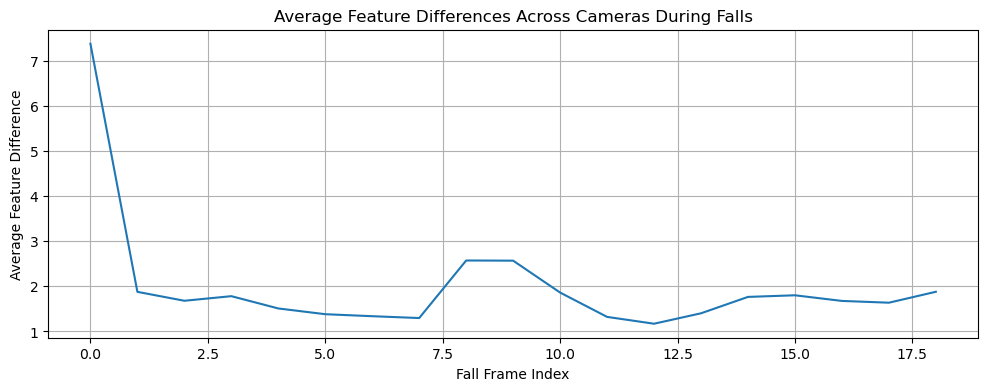

## Normalized Features all cams

Average feature difference across cameras during falls: 0.9139


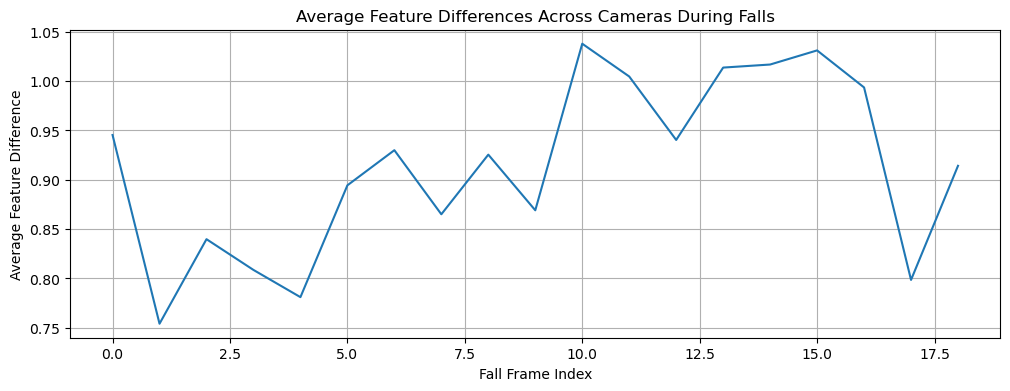

(0.91387177,
 [0.94535196,
  0.75418186,
  0.8398181,
  0.8086726,
  0.7811025,
  0.8943799,
  0.9299641,
  0.8650463,
  0.9254624,
  0.869094,
  1.0378236,
  1.004631,
  0.9403433,
  1.0136551,
  1.0167466,
  1.0310524,
  0.9935331,
  0.79856163,
  0.91414344])

In [88]:
# Calculate differences between features during fall events only
def analyze_feature_differences(features_all_cams):
    fall_frame_groups = {}

    # Group features by camera for frames where label=1
    for video_data in features_all_cams:
        features = video_data['features']
        labels = video_data['labels']
        cam = video_data['cam']
        
        # Only include frames where label=1 (fall occurring)
        fall_frames = features[labels == 1]
        
        # Store features by frame index
        for frame_idx, feature in enumerate(fall_frames):
            if frame_idx not in fall_frame_groups:
                fall_frame_groups[frame_idx] = []
            fall_frame_groups[frame_idx].append(feature)

    # Calculate differences between features at each frame
    frame_diffs = []
    frame_avg_diffs = []

    for frame_idx, frame_features in fall_frame_groups.items():
        if len(frame_features) > 1:  # Need at least 2 cameras to compare
            frame_diff = []
            # Calculate pairwise differences between all cameras for this frame
            for i in range(len(frame_features)):
                for j in range(i+1, len(frame_features)):
                    diff = np.mean(np.abs(frame_features[i] - frame_features[j]))
                    frame_diff.append(diff)
            frame_diffs.append(frame_diff)
            frame_avg_diffs.append(np.mean(frame_diff))

    # Overall average difference across all fall frames
    overall_avg_diff = np.mean(frame_avg_diffs)
    print(f"Average feature difference across cameras during falls: {overall_avg_diff:.4f}")

    # Plot per-frame differences
    plt.figure(figsize=(12,4))
    plt.plot(frame_avg_diffs)
    plt.title('Average Feature Differences Across Cameras During Falls')
    plt.xlabel('Fall Frame Index') 
    plt.ylabel('Average Feature Difference')
    plt.grid(True)
    plt.show()
    
    return overall_avg_diff, frame_avg_diffs

features_all_cams = []
for i, video_data in enumerate(chute1_data):
    chute = video_data['chute']
    cam = video_data['cam']
    features = video_data['features']
    labels = video_data['labels']
    features_all_cams.append({
        'chute': chute,
        'cam': cam,
        'features': features,
        'labels': labels
    })

display(Markdown("## Original Features all cams"))
analyze_feature_differences(features_all_cams)

display(Markdown("## Normalized Features all cams"))
analyze_feature_differences(norm_features_all_cams)

### Observations

* While the different camera angles of the same fall are still different, the difference is not as extreme as before. 
* When combined with camera metadata, the model may be better able to generalize. 

In [24]:
#Train/Val/Test split
df_fall_videos = df[(df['label'] == 1)]
seed = 42

# Split data into train/val/test sets
df_test = df_fall_videos.groupby('chute').sample(frac=0.2, random_state=seed)
df_remaining = df_fall_videos.drop(df_test.index)

# Split remaining data into train/val
df_train = df_remaining.groupby('chute').sample(frac=0.6, random_state=seed)
df_val = df_remaining.drop(df_train.index)

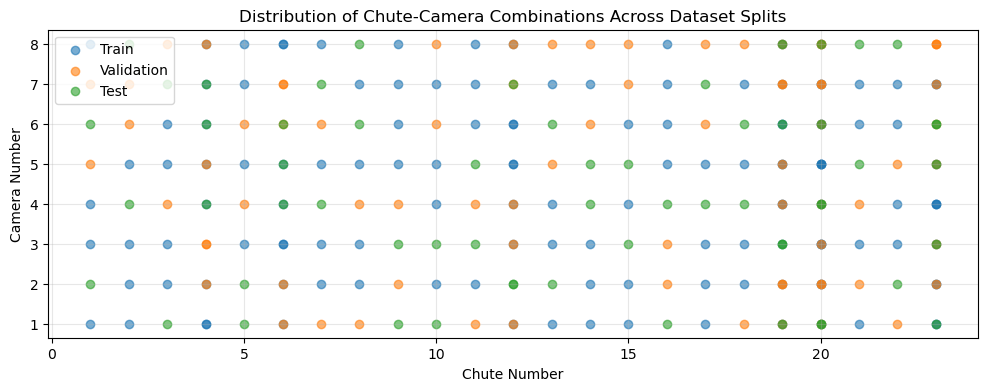

In [25]:
# Create scatterplot of chute vs cam colored by dataset split
plt.figure(figsize=(12, 4))
plt.scatter(df_train['chute'], df_train['cam'], label='Train', alpha=0.6)
plt.scatter(df_val['chute'], df_val['cam'], label='Validation', alpha=0.6) 
plt.scatter(df_test['chute'], df_test['cam'], label='Test', alpha=0.6)

plt.xlabel('Chute Number')
plt.ylabel('Camera Number')
plt.title('Distribution of Chute-Camera Combinations Across Dataset Splits')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [709]:
train_data = get_data_for_videos(df_train, limit_to_prepost_frames=True)
val_data = get_data_for_videos(df_val, limit_to_prepost_frames=True)
test_data = get_data_for_videos(df_test, limit_to_prepost_frames=True)

Processing videos:   0%|          | 0/130 [00:00<?, ?it/s, cam=1, chute=1][mpeg4 @ 0x3e8e77020] ac-tex damaged at 3 19
[mpeg4 @ 0x3e8e77020] Error at MB: 877
Processing videos:   1%|          | 1/130 [00:00<01:15,  1.71it/s, cam=3, chute=1][mpeg4 @ 0x48972ba20] ac-tex damaged at 24 17
[mpeg4 @ 0x48972ba20] Error at MB: 806
Processing videos:   2%|▏         | 3/130 [00:01<01:14,  1.71it/s, cam=4, chute=1][mpeg4 @ 0x48971dfe0] ac-tex damaged at 13 23
[mpeg4 @ 0x48971dfe0] Error at MB: 1071
Processing videos:   5%|▍         | 6/130 [00:03<00:57,  2.15it/s, cam=2, chute=2][mpeg4 @ 0x3ef979d20] ac-tex damaged at 38 16
[mpeg4 @ 0x3ef979d20] Error at MB: 774
Processing videos:   5%|▌         | 7/130 [00:03<01:03,  1.93it/s, cam=3, chute=2][mpeg4 @ 0x490a18380] mcbpc damaged at 30 8
[mpeg4 @ 0x490a18380] Error at MB: 398
Processing videos:   6%|▌         | 8/130 [00:04<00:56,  2.14it/s, cam=6, chute=3][mpeg4 @ 0x4b1b2a3e0] ac-tex damaged at 10 25
[mpeg4 @ 0x4b1b2a3e0] Error at MB: 1160
Process

In [27]:
dataset_name = 'pose_features_cam_normalized_overlap'

In [ ]:
# Save all datasets
with open(f'{dataset_name}_train_data.pkl', 'wb') as f:
    pickle.dump(train_data, f)
with open(f'{dataset_name}_val_data.pkl', 'wb') as f:
    pickle.dump(val_data, f)
with open(f'{dataset_name}_test_data.pkl', 'wb') as f:
    pickle.dump(test_data, f)

In [28]:
# Load all the datasets for training
with open(f'{dataset_name}_train_data.pkl', 'rb') as f:
    train_data_loaded = pickle.load(f)
with open(f'{dataset_name}_val_data.pkl', 'rb') as f:
    val_data_loaded = pickle.load(f)
with open(f'{dataset_name}_test_data.pkl', 'rb') as f:
    test_data_loaded = pickle.load(f)

### Prepare training data

* Remove any videos where video processing errors resulted in empty X_train_windows
* Enrich training windows with camera metadata for the matching cameras


In [29]:
CAM_METADATA_FILE = '../EDA/multicam_cam_metadata_normalized.csv'
dfCamMetadata = pd.read_csv(CAM_METADATA_FILE)
dfCamMetadata.head(2)

def get_cam_metadata(cam_num):
    return dfCamMetadata[dfCamMetadata[f'camera_{int(cam_num)}'] == 1].iloc[0].values

cam_metadata_example = get_cam_metadata(1)
CAM_PREFIX_LENGTH = len(cam_metadata_example)
print(cam_metadata_example)
print(f"CAM_PREFIX_LENGTH: {CAM_PREFIX_LENGTH}")
        

[          1           0           0           0           0           0           0           0     0.78204     0.72812    -0.69468      -1.259     0.81696     -1.1293    -0.57337     -1.7582     0.97586     0.97527      1.8511      1.2524    -0.80287    0.029465    -0.83032       1.093     0.27564     -1.5029
      -0.989     0.43511]
CAM_PREFIX_LENGTH: 28


In [102]:
OMIT_CAMERAS = [6, 7, 8]
OMIT_CHUTES = [4,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
# OMIT_CHUTES = [4,9,13,14,15,16,17,18,21,22,23,24]

train_data_loaded_clean = [video for video in train_data_loaded if len(video['X_train_windows'].shape) > 1 and video['cam'] not in OMIT_CAMERAS and video['chute'] not in OMIT_CHUTES]
val_data_loaded_clean = [video for video in val_data_loaded if len(video['X_train_windows'].shape) > 1 and video['cam'] not in OMIT_CAMERAS and video['chute'] not in OMIT_CHUTES]
test_data_loaded_clean = [video for video in test_data_loaded if len(video['X_train_windows'].shape) > 1 and video['cam'] not in OMIT_CAMERAS and video['chute'] not in OMIT_CHUTES]

print(f"Training Videos: {len(train_data_loaded_clean)} out of {len(train_data_loaded)}")
print(f"Validation Videos: {len(val_data_loaded_clean)} out of {len(val_data_loaded)}")
print(f"Test Videos: {len(test_data_loaded_clean)} out of {len(test_data_loaded)}")

# Print unique chute/cam combinations in each dataset
print("\nTraining Dataset Chute/Cam Combinations:")
train_combos = pd.DataFrame([(v['chute'], v['cam']) for v in train_data_loaded_clean], 
                           columns=['chute', 'cam']).drop_duplicates()
print(train_combos.sort_values(['chute', 'cam']))

print("\nValidation Dataset Chute/Cam Combinations:") 
val_combos = pd.DataFrame([(v['chute'], v['cam']) for v in val_data_loaded_clean],
                         columns=['chute', 'cam']).drop_duplicates()
print(val_combos.sort_values(['chute', 'cam']))

print("\nTest Dataset Chute/Cam Combinations:")
test_combos = pd.DataFrame([(v['chute'], v['cam']) for v in test_data_loaded_clean],
                          columns=['chute', 'cam']).drop_duplicates()
print(test_combos.sort_values(['chute', 'cam']))




Training Videos: 24 out of 130
Validation Videos: 8 out of 75
Test Videos: 8 out of 59

Training Dataset Chute/Cam Combinations:
    chute  cam
0     1.0  1.0
1     1.0  3.0
2     1.0  4.0
4     2.0  1.0
5     2.0  2.0
6     2.0  3.0
3     2.0  5.0
8     3.0  2.0
7     3.0  3.0
9     3.0  5.0
11    5.0  3.0
10    5.0  5.0
12    6.0  1.0
17    6.0  2.0
13    6.0  3.0
16    6.0  4.0
15    6.0  5.0
19    7.0  2.0
20    7.0  3.0
18    7.0  5.0
23    8.0  2.0
21    8.0  3.0
22    8.0  5.0

Validation Dataset Chute/Cam Combinations:
   chute  cam
0    1.0  5.0
1    3.0  4.0
2    5.0  4.0
3    6.0  1.0
4    6.0  2.0
5    7.0  1.0
6    8.0  1.0
7    8.0  4.0

Test Dataset Chute/Cam Combinations:
   chute  cam
0    1.0  2.0
1    2.0  4.0
2    3.0  1.0
3    5.0  1.0
4    5.0  2.0
6    6.0  4.0
5    6.0  5.0
7    7.0  4.0


In [103]:

# Combine X_train_windows and y_train_windows from all videos in train_data_loaded
X_train_windows = np.concatenate([video['X_train_windows'] for video in train_data_loaded_clean])
# Get the camera metadata to be added to the beginning of each window
X_train_cam_prefix = np.concatenate([np.tile(get_cam_metadata(video['cam']), (video['X_train_windows'].shape[0], 1)) for video in train_data_loaded_clean])
# Reshape X_train_cam_prefix to match the number of frames (e.g. 30) for each window
X_train_cam_prefix_expanded = np.repeat(X_train_cam_prefix[:, np.newaxis, :], X_train_windows.shape[1], axis=1)
# Concatenate the camera metadata prefix with the window features along the last axis
X_train_windows = np.concatenate([X_train_cam_prefix_expanded, X_train_windows], axis=2)
y_train_windows = np.concatenate([video['y_train_windows'] for video in train_data_loaded_clean])

print("Combined shape of X_train_windows:", X_train_windows.shape)
print("Combined shape of y_train_windows:", y_train_windows.shape)

# Combine X_train_windows and y_train_windows from all videos in val_data_loaded
X_val_windows = np.concatenate([video['X_train_windows'] for video in val_data_loaded_clean])
X_val_cam_prefix = np.concatenate([np.tile(get_cam_metadata(video['cam']), (video['X_train_windows'].shape[0], 1)) for video in val_data_loaded_clean])
# Reshape X_val_cam_prefix to match the number of frames (e.g. 30) for each window
X_val_cam_prefix_expanded = np.repeat(X_val_cam_prefix[:, np.newaxis, :], X_val_windows.shape[1], axis=1)
# Concatenate the camera metadata prefix with the window features along the last axis
X_val_windows = np.concatenate([X_val_cam_prefix_expanded, X_val_windows], axis=2)
y_val_windows = np.concatenate([video['y_train_windows'] for video in val_data_loaded_clean])

print("Combined shape of X_val_windows:", X_val_windows.shape)
print("Combined shape of y_val_windows:", y_val_windows.shape)

# Combine X_train_windows and y_train_windows from all videos in test_data_loaded
X_test_windows = np.concatenate([video['X_train_windows'] for video in test_data_loaded_clean])
X_test_cam_prefix = np.concatenate([np.tile(get_cam_metadata(video['cam']), (video['X_train_windows'].shape[0], 1)) for video in test_data_loaded_clean])
# Reshape X_test_cam_prefix to match the number of frames (e.g. 30) for each window
X_test_cam_prefix_expanded = np.repeat(X_test_cam_prefix[:, np.newaxis, :], X_test_windows.shape[1], axis=1)
# Concatenate the camera metadata prefix with the window features along the last axis
X_test_windows = np.concatenate([X_test_cam_prefix_expanded, X_test_windows], axis=2)
y_test_windows = np.concatenate([video['y_train_windows'] for video in test_data_loaded_clean])

print("Combined shape of X_test_windows:", X_test_windows.shape)
print("Combined shape of y_test_windows:", y_test_windows.shape)

Combined shape of X_train_windows: (504, 30, 127)
Combined shape of y_train_windows: (504,)
Combined shape of X_val_windows: (168, 30, 127)
Combined shape of y_val_windows: (168,)
Combined shape of X_test_windows: (168, 30, 127)
Combined shape of y_test_windows: (168,)


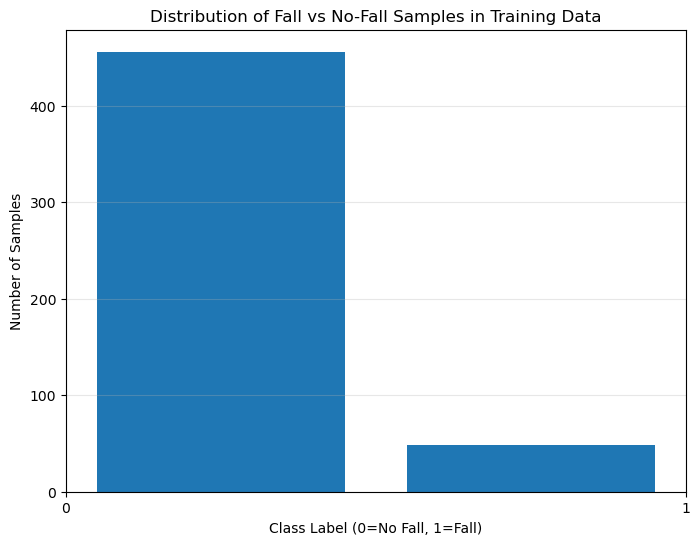

In [104]:
# Plot distribution of fall vs no-fall samples
plt.figure(figsize=(8, 6))
plt.hist(y_train_windows, bins=2, rwidth=0.8)
plt.title('Distribution of Fall vs No-Fall Samples in Training Data')
plt.xlabel('Class Label (0=No Fall, 1=Fall)')
plt.ylabel('Number of Samples')
plt.xticks([0, 1])
plt.grid(True, alpha=0.3)


### Bootstrap Augmentation using jittering to add variation without losing motion patterns

In [105]:
def jitter_sequence(sequence, noise_level=0.01, fixed_value_prefix=CAM_PREFIX_LENGTH):
    """
    Applies small random noise to a time-series sequence to simulate natural variability.

    Args:
        sequence (np.ndarray): Shape (window_size, features)
        noise_level (float): Amount of noise to add

    Returns:
        np.ndarray: Augmented sequence
    """
    # Create noise array of same shape as sequence
    noise = np.random.normal(0, noise_level, sequence.shape)
    # Zero out noise for fixed prefix values
    noise[:, :fixed_value_prefix] = 0
    return sequence + noise

# Calculate number of fall and no-fall samples
n_no_falls = np.sum(y_train_windows == 0)
n_falls = np.sum(y_train_windows == 1)
n_synthetic_needed = n_no_falls - n_falls

print(f"No-fall samples: {n_no_falls}")
print(f"Fall samples: {n_falls}") 
print(f"Synthetic samples needed: {n_synthetic_needed}")

# Get indices of fall samples
fall_indices = np.where(y_train_windows == 1)[0]

# Generate synthetic samples by jittering existing fall sequences
synthetic_X = []
synthetic_y = []

# Randomly sample with replacement from existing fall sequences
for _ in range(n_synthetic_needed):
    # Randomly select a fall sequence
    idx = np.random.choice(fall_indices)
    # Apply jittering to create synthetic sequence
    synthetic_seq = jitter_sequence(X_train_windows[idx], noise_level=0.01)
    synthetic_X.append(synthetic_seq)
    synthetic_y.append(1)

# Convert to numpy arrays
synthetic_X = np.array(synthetic_X)
synthetic_y = np.array(synthetic_y)

# Combine original and synthetic data
X_train_windows_balanced = np.concatenate([X_train_windows, synthetic_X])
y_train_windows_balanced = np.concatenate([y_train_windows, synthetic_y])

print("\nAfter augmentation:")
print(f"Total samples: {len(y_train_windows_balanced)}")
print(f"Fall samples: {np.sum(y_train_windows_balanced == 1)}")
print(f"No-fall samples: {np.sum(y_train_windows_balanced == 0)}")


No-fall samples: 456
Fall samples: 48
Synthetic samples needed: 408

After augmentation:
Total samples: 912
Fall samples: 456
No-fall samples: 456


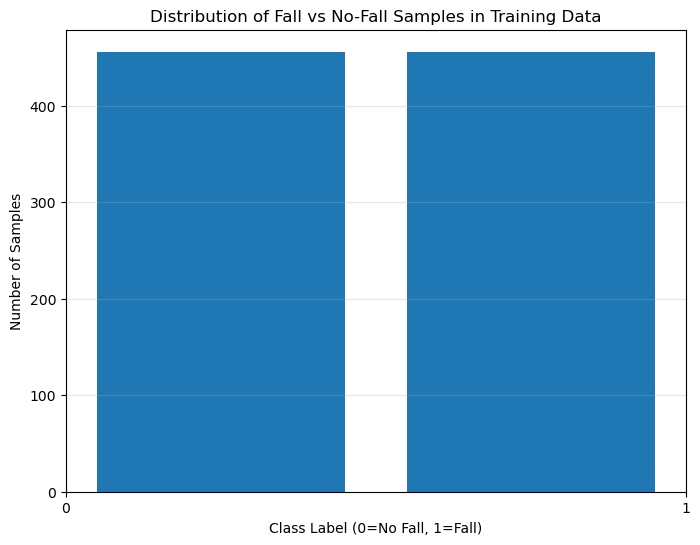

In [106]:
# Plot distribution of fall vs no-fall samples
plt.figure(figsize=(8, 6))
plt.hist(y_train_windows_balanced, bins=2, rwidth=0.8)
plt.title('Distribution of Fall vs No-Fall Samples in Training Data')
plt.xlabel('Class Label (0=No Fall, 1=Fall)')
plt.ylabel('Number of Samples')
plt.xticks([0, 1])
plt.grid(True, alpha=0.3)


In [107]:
from sklearn.utils.class_weight import compute_class_weight

def compute_class_weights(y_train_windows):
    # Compute class weights with a maximum ratio cap
    class_weights = compute_class_weight("balanced", classes=np.array([0, 1]), y=y_train_windows.flatten())
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
    print(f"Computed class weights: {class_weight_dict}")# Cap the ratio between classes to prevent extreme weights
    max_ratio = 10.0
    if class_weights[1] / class_weights[0] > max_ratio:
        class_weights[1] = class_weights[0] * max_ratio
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
    print(f"Adjusted class weights: {class_weight_dict}")
    return class_weight_dict

class_weight_dict = compute_class_weights(y_train_windows)

Computed class weights: {0: 0.5526315789473685, 1: 5.25}
Adjusted class weights: {0: 0.5526315789473685, 1: 5.25}


In [108]:
class WeightedBinaryCrossentropy(tf.keras.losses.Loss):
    """
    Custom loss function that applies higher weights to false positives.
    """
    def __init__(self, false_positive_weight=1.5, name='weighted_binary_crossentropy'):
        super().__init__(name=name)
        self.false_positive_weight = false_positive_weight

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        # Reshape y_true to match y_pred shape
        y_true = tf.reshape(y_true, tf.shape(y_pred))
        
        # Calculate binary crossentropy
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        
        # Apply higher weights to false positives
        weights = tf.where(tf.equal(y_true, 0),
                        self.false_positive_weight,  # False positive weight
                        1.0)  # Weight for other cases
        
        return tf.reduce_mean(bce * weights)
    
def focal_loss(alpha=0.25, gamma=2.0):
    """
    Focal Loss for class imbalance.
    
    Args:
        alpha (float): Scaling factor for rare class
        gamma (float): Focus parameter
    
    Returns:
        Loss function for Keras model
    """
    def loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)  # Avoid log(0)
        pt = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        return -K.mean(alpha * K.pow(1. - pt, gamma) * K.log(pt))
    
    return loss

In [109]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import backend as K

NUM_FEATURES = X_val_windows.shape[2]

def build_real_time_cnn_lstm():
    """
    Builds an updated CNN + LSTM model with additional regularization.

    Returns:
        model: Keras model
    """
    REGULARIZATION_PENALTY = 0.2
    RECURRENT_REGULARIZATION_PENALTY = 0.3
    model = Sequential([
        Input(shape=(NUM_WINDOW_FRAMES, NUM_FEATURES)),
        # Increase dropout and L2 regularization
        LSTM(128, return_sequences=True, 
             kernel_regularizer=tf.keras.regularizers.l2(REGULARIZATION_PENALTY),
             recurrent_regularizer=tf.keras.regularizers.l2(RECURRENT_REGULARIZATION_PENALTY)),
        BatchNormalization(),
        Dropout(0.5),  # Increased from 0.4
        
        LSTM(64, return_sequences=False,
             kernel_regularizer=tf.keras.regularizers.l2(REGULARIZATION_PENALTY),
             recurrent_regularizer=tf.keras.regularizers.l2(RECURRENT_REGULARIZATION_PENALTY)),
        BatchNormalization(),
        Dropout(0.5),  # Increased from 0.4
        
        Dense(32, activation="relu", 
              kernel_regularizer=tf.keras.regularizers.l2(REGULARIZATION_PENALTY)),
        Dropout(0.3),  # Added dropout before final layer
        Dense(1, activation="sigmoid")
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005) 
    model.compile(
                #   loss="binary_crossentropy",
                  # loss=focal_loss(alpha=0.75, gamma=0.5),
                  loss=WeightedBinaryCrossentropy(false_positive_weight=1.1), 
                  optimizer=optimizer, 
                  metrics=[
                        tf.keras.metrics.AUC(name='auc'),  # ROC AUC
                        tf.keras.metrics.Precision(name='precision'),  # Precision for falls
                        tf.keras.metrics.Recall(name='recall'),  # Recall for falls
                    ]
    )
    return model

In [110]:
# Initialize and check the model
model = build_real_time_cnn_lstm()
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 30, 128)        │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 30, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,361 (716.25 KB)

 Trainable params: 182,977 (714.75 KB)

 Non-trainable params: 384 (1.50 KB)

In [112]:
X_train = X_train_windows_balanced
y_train = y_train_windows_balanced

# Add callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    patience=15,        # Increased patience to allow for longer training
    restore_best_weights=True,
    mode='max',
    min_delta=0.001    # Minimum change to qualify as an improvement
)

reduce_lr_aggressive = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.5,        # More aggressive reduction in learning rate
    patience=5,        # Reduced patience to respond faster to plateaus
    min_lr=0.0000001,  # Lower minimum learning rate
    mode='max',
    min_delta=0.0005   # Smaller minimum change threshold to be more sensitive
)

reduce_lr_moderate = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.7,        # More moderate reduction in learning rate
    patience=8,        # More patience before reducing learning rate
    min_lr=0.000001,   # Slightly higher minimum learning rate
    mode='max',
    min_delta=0.001    # Larger minimum change threshold to be less sensitive
)

# Train the model with callbacks
history = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    batch_size=32,  # Increased batch size for better stability
    validation_data=(X_val_windows, y_val_windows),
    class_weight=class_weight_dict,
    # callbacks=[early_stopping, reduce_lr]
    callbacks=[reduce_lr_moderate]
)

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - auc: 0.4455 - loss: 143.3982 - precision: 0.4365 - recall: 0.4399 - val_auc: 0.4786 - val_loss: 137.3063 - val_precision: 0.0933 - val_recall: 0.4375 - learning_rate: 5.0000e-05
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.5992 - loss: 138.5244 - precision: 0.5659 - recall: 0.6090 - val_auc: 0.6367 - val_loss: 133.3140 - val_precision: 0.1149 - val_recall: 0.6250 - learning_rate: 5.0000e-05
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.6035 - loss: 134.3546 - precision: 0.5814 - recall: 0.5633 - val_auc: 0.7619 - val_loss: 129.3994 - val_precision: 0.1616 - val_recall: 1.0000 - learning_rate: 5.0000e-05
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.7214 - loss: 129.8632 - precision: 0.6439 - recall: 0.6683 - val_auc: 0.8248 - val_loss: 125.5584 - val_precision: 0.1720 - val_recall: 1.0000 - learning_rate: 5.0000e-05
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.7687 - loss

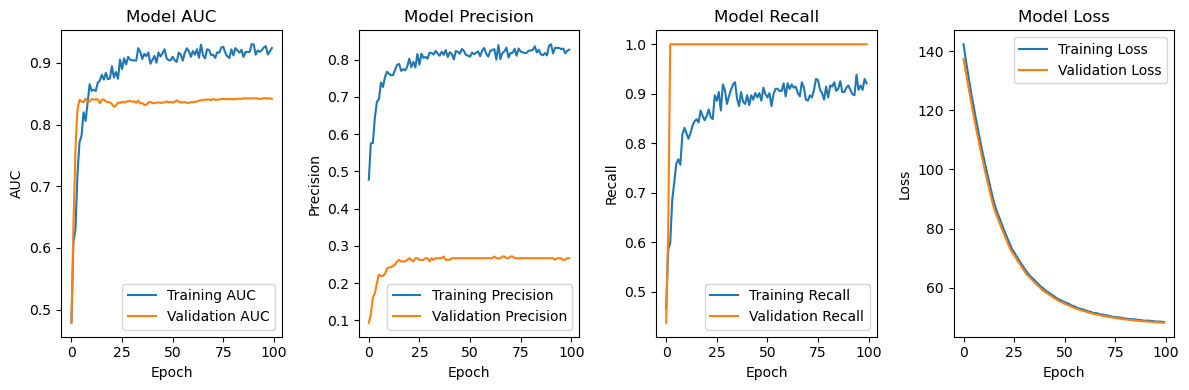

In [113]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation AUC
plt.subplot(1, 4, 1)
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

# Plot training & validation precision
plt.subplot(1, 4, 2)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Plot training & validation recall
plt.subplot(1, 4, 3)
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 4, 4)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


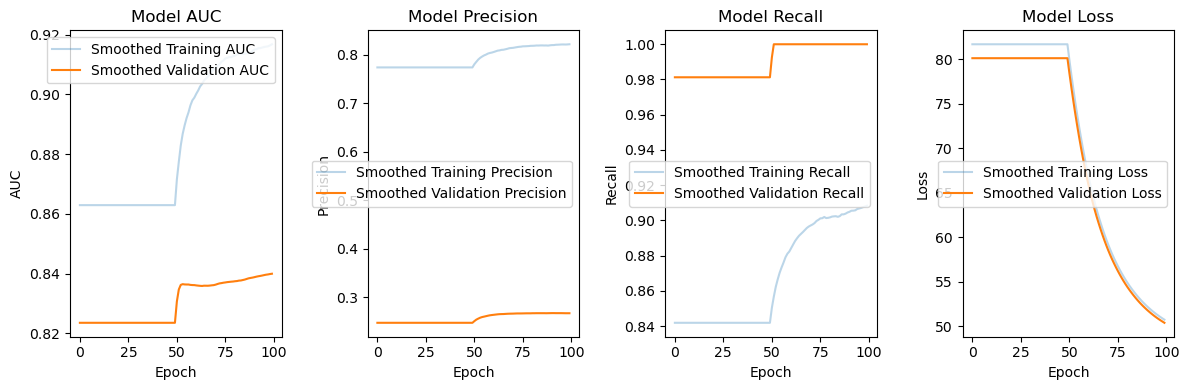

In [114]:
def plot_smoothed_history(history, window_size=5):
    """Plot training history with smoothed validation metrics"""
    plt.figure(figsize=(12, 4))
    
    # Helper function for smoothing
    def smooth(y, box_pts):
        box = np.ones(box_pts)/box_pts
        y_smooth = np.convolve(y, box, mode='valid')
        # Pad the beginning to maintain array size
        pad_size = len(y) - len(y_smooth)
        return np.pad(y_smooth, (pad_size, 0), 'edge')
    
    # Plot training & validation AUC
    plt.subplot(1, 4, 1)
    plt.plot(smooth(history.history['auc'], window_size), 
             label='Smoothed Training AUC', alpha=0.3)
    plt.plot(smooth(history.history['val_auc'], window_size), 
             label='Smoothed Validation AUC')
    plt.title('Model AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    
    # Plot training & validation precision
    plt.subplot(1, 4, 2)
    plt.plot(smooth(history.history['precision'], window_size), 
             label='Smoothed Training Precision', alpha=0.3)
    plt.plot(smooth(history.history['val_precision'], window_size), 
             label='Smoothed Validation Precision')
    plt.title('Model Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()

    # Plot training & validation recall
    plt.subplot(1, 4, 3)
    plt.plot(smooth(history.history['recall'], window_size), 
             label='Smoothed Training Recall', alpha=0.3)
    plt.plot(smooth(history.history['val_recall'], window_size), 
             label='Smoothed Validation Recall')
    plt.title('Model Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()

    # Plot training & validation loss
    plt.subplot(1, 4, 4)
    plt.plot(smooth(history.history['loss'], window_size), 
             label='Smoothed Training Loss', alpha=0.3)
    plt.plot(smooth(history.history['val_loss'], window_size), 
             label='Smoothed Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# After training, plot the smoothed history
plot_smoothed_history(history, window_size=50)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


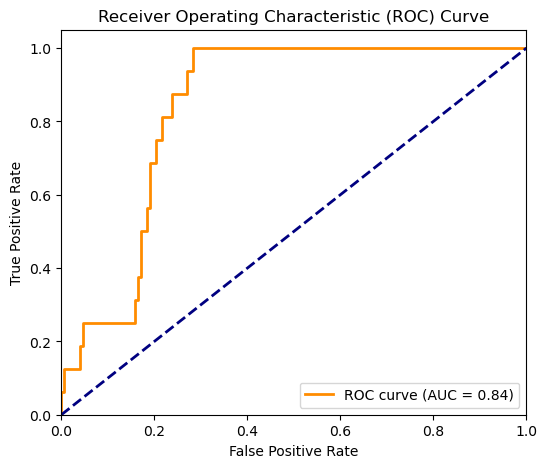

In [115]:
# Plot ROC-AUC curve

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get prediction probabilities
val_pred_probs = model.predict(X_val_windows)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_val_windows, val_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Validation Classification Report:
              precision    recall  f1-score   support

     No Fall       1.00      0.71      0.83       152
        Fall       0.27      1.00      0.42        16

    accuracy                           0.74       168
   macro avg       0.63      0.86      0.63       168
weighted avg       0.93      0.74      0.79       168

Validation ROC-AUC Score: 0.8553


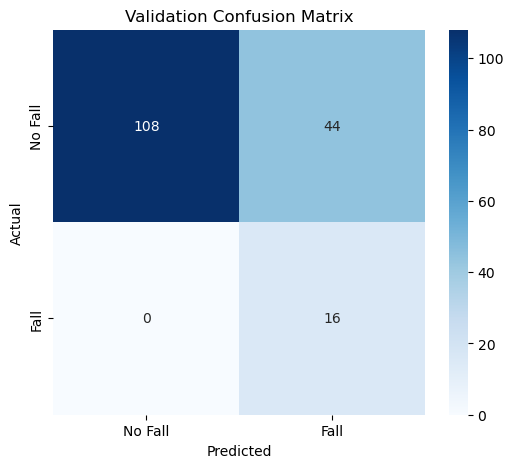

In [129]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Generate predictions on validation data
val_predictions = model.predict(X_val_windows)
val_predictions = (val_predictions > 0.5).astype(int)  # Convert to binary predictions

# Print classification report for validation set
print("Validation Classification Report:")
print(classification_report(y_val_windows, val_predictions, target_names=["No Fall", "Fall"]))

# Compute ROC-AUC for validation set
val_roc_auc = roc_auc_score(y_val_windows, val_predictions)
print(f"Validation ROC-AUC Score: {val_roc_auc:.4f}")

# Plot confusion matrix for validation set
plt.figure(figsize=(6, 5))
val_cm = confusion_matrix(y_val_windows, val_predictions)
sns.heatmap(val_cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fall", "Fall"], yticklabels=["No Fall", "Fall"])
plt.xlabel("Predicted")
plt.ylabel("Actual") 
plt.title("Validation Confusion Matrix")
plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


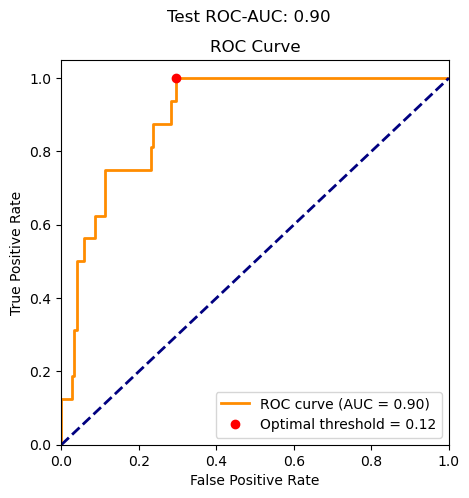

In [132]:
# Plot ROC-AUC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get prediction probabilities
test_pred_probs = model.predict(X_test_windows)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_windows, test_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve and find optimal threshold
# Calculate Youden's J statistic to find optimal threshold
J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold = thresholds[optimal_idx]

# Create figure with two subplots
fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))
fig.suptitle(f'Test ROC-AUC: {roc_auc:.2f}')
# Plot ROC curve
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', label=f'Optimal threshold = {optimal_threshold:.2f}')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')
ax1.legend(loc="lower right")

In [126]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Generate predictions
test_predictions = model.predict(X_test_windows)
test_predictions = (test_predictions > optimal_threshold).astype(int)  # Convert to binary predictions using optimal threshold

# Compute detailed metrics
print("Classification Report:")
print(classification_report(y_test_windows, test_predictions, target_names=["No Fall", "Fall"]))

# Compute ROC-AUC
roc_auc = roc_auc_score(y_test_windows, test_predictions)
print(f"ROC-AUC Score: {roc_auc:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Classification Report:
              precision    recall  f1-score   support

     No Fall       0.99      0.70      0.82       152
        Fall       0.25      0.94      0.39        16

    accuracy                           0.73       168
   macro avg       0.62      0.82      0.61       168
weighted avg       0.92      0.73      0.78       168

ROC-AUC Score: 0.8207


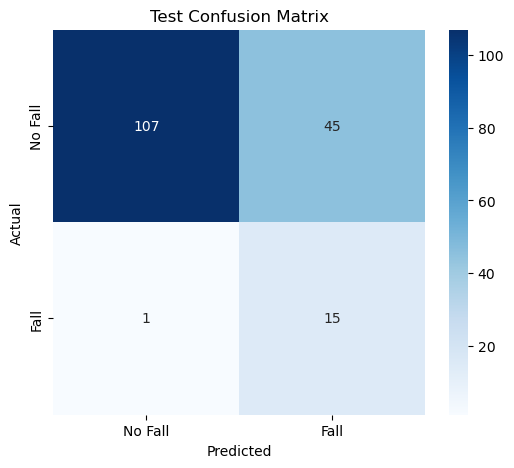

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test_windows, test_predictions)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fall", "Fall"], yticklabels=["No Fall", "Fall"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test Confusion Matrix")
plt.show()

In [120]:
# Save the best model
file_name = 'fall_prediction_model_v6_3dpose_norm_overlap_limited_chutes.keras'
model.save(file_name)
print(f"Model saved successfully as '{file_name}'")


Model saved successfully as 'fall_prediction_model_v6_3dpose_norm_overlap_limited_chutes.keras'


In [344]:
model.load_weights(file_name)